In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBRegressor
import pickle

# Set random seed for reproducibility
RANDOM_SEED = 2023
np.random.seed(RANDOM_SEED)



In [126]:
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

#### Configuration

In [127]:
# Define paths
DATA_PATH = '../data/'
MODEL_PATH = './models/'
OUTPUT_PATH = './outputs/'

# Create directories if they don't exist
import os
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(OUTPUT_PATH, exist_ok=True)

print("Project setup completed")

Project setup completed


#### 1. DATA LOADING

In [128]:

#############################################################
# 1. DATA LOADING 
#############################################################

# Load the data (adjust paths as needed)
train_path = DATA_PATH + 'train_updated.csv'
test_path = DATA_PATH + 'test_updated.csv'




dt = pd.read_csv(train_path, low_memory=False) # train data
dt_test = pd.read_csv(test_path, low_memory=False) # test data


print('Train data shape:', dt.shape, 'Test data shape:', dt_test.shape)


Train data shape: (1118822, 52) Test data shape: (9272, 51)


#### XY Coordinates Column Correction

In [129]:
# After loading train and test data
dt['temp'] = dt['좌표X']
dt['좌표X'] = dt['좌표Y']
dt['좌표Y'] = dt['temp']
dt.drop('temp', axis=1, inplace=True)

# Same for test data
dt_test['temp'] = dt_test['좌표X']
dt_test['좌표X'] = dt_test['좌표Y'] 
dt_test['좌표Y'] = dt_test['temp']
dt_test.drop('temp', axis=1, inplace=True)

In [130]:
subway_data_path = DATA_PATH + 'subway_feature.csv'
bus_data_path = DATA_PATH + 'bus_feature.csv'

# Load transportation data
subway_data = pd.read_csv(subway_data_path)
bus_data = pd.read_csv(bus_data_path)



In [131]:

# Display basic information
print("Train data shape:", dt.shape)
print("Subway data shape:", subway_data.shape)
print("Bus data shape:", bus_data.shape)

# Preview the data
print("\nSubway data preview:")
display(subway_data.head())

print("\nBus data preview:")
display(bus_data.head())

print("\Train data preview:")
display(dt.head())

Train data shape: (1118822, 52)
Subway data shape: (768, 5)
Bus data shape: (12584, 6)

Subway data preview:


,역사_ID,역사명,호선,위도,경도
0,9996,미사,5호선,37.560927,127.193877
1,9995,강일,5호선,37.557490,127.175930
2,4929,김포공항,김포골드라인,37.562360,126.801868
3,4928,고촌,김포골드라인,37.601243,126.770345
4,4927,풍무,김포골드라인,37.612488,126.732387



Bus data preview:


,노드 ID,정류소번호,정류소명,X좌표,Y좌표,정류소 타입
0,100000001,1001,종로2가사거리,126.987752,37.569808,중앙차로
1,100000002,1002,창경궁.서울대학교병원,126.996566,37.579183,중앙차로
2,100000003,1003,명륜3가.성대입구,126.998251,37.582581,중앙차로
3,100000004,1004,종로2가.삼일교,126.987613,37.568579,중앙차로
4,100000005,1005,혜화동로터리.여운형활동터,127.001744,37.586243,중앙차로


\Train data preview:


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,37.476763,127.05721,2022-11-17 10:19:06.0,124000
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,37.476763,127.05721,2022-11-17 10:19:06.0,123500
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,37.476763,127.05721,2022-11-17 10:19:06.0,91500
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,37.476763,127.05721,2022-11-17 10:19:06.0,130000
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,37.476763,127.05721,2022-11-17 10:19:06.0,117000


#### Column correction (Transportation data)

In [132]:
# Add this after loading subway_data and bus_data
# Standardize column names to match train/test dataset terminology

# 1. Rename subway data columns
# Current: '위도' (latitude) -> 좌표X
#          '경도' (longitude) -> 좌표Y
subway_data = subway_data.rename(columns={
    '위도': '좌표X',
    '경도': '좌표Y'
})


# # 2. Rename bus data columns
# Current: 'Y좌표' (latitude) -> 좌표X
#          'X좌표' (longitude) -> 좌표Y
bus_data = bus_data.rename(columns={
    'Y좌표': '좌표X',
    'X좌표': '좌표Y'
})

#### Validation to ensure coordinate ranges are correct (Transportation data)

In [133]:

def validate_transportation_coordinates(df, name):
    valid_lat = (df['좌표X'] >= 37.4) & (df['좌표X'] <= 37.7)
    valid_lon = (df['좌표Y'] >= 126.7) & (df['좌표Y'] <= 127.2)
    
    if not (valid_lat & valid_lon).all():
        print(f"Warning: {(~(valid_lat & valid_lon)).sum()} {name} coordinates outside expected ranges")
    else:
        print(f"All {name} coordinates valid after renaming")

# Validate both datasets after renaming
validate_transportation_coordinates(subway_data, "subway")
validate_transportation_coordinates(bus_data, "bus")

# Display sample to confirm renaming
print("\nSubway data after renaming:")
print(subway_data[['역사_ID', '역사명', '호선', '좌표X', '좌표Y']].head())

print("\nBus data after renaming:")
print(bus_data[['노드 ID', '정류소번호', '정류소명', '좌표X', '좌표Y']].head())

All bus coordinates valid after renaming

Subway data after renaming:
   역사_ID   역사명      호선        좌표X         좌표Y
0   9996    미사     5호선  37.560927  127.193877
1   9995    강일     5호선  37.557490  127.175930
2   4929  김포공항  김포골드라인  37.562360  126.801868
3   4928    고촌  김포골드라인  37.601243  126.770345
4   4927    풍무  김포골드라인  37.612488  126.732387

Bus data after renaming:
       노드 ID  정류소번호           정류소명        좌표X         좌표Y
0  100000001   1001        종로2가사거리  37.569808  126.987752
1  100000002   1002    창경궁.서울대학교병원  37.579183  126.996566
2  100000003   1003      명륜3가.성대입구  37.582581  126.998251
3  100000004   1004       종로2가.삼일교  37.568579  126.987613
4  100000005   1005  혜화동로터리.여운형활동터  37.586243  127.001744


#### Coordinate Row Correction

In [134]:
def correct_coordinates_enhanced(df):
    df_corrected = df.copy()
    
    # Case 1: Clear swaps (X > 100, Y < 100)
    swap_mask1 = (df['좌표X'] > 100) & (df['좌표Y'] < 100)
    
    # Case 2: X is in latitude range but Y isn't in longitude range
    swap_mask2 = ((df['좌표X'] >= 33) & (df['좌표X'] <= 43) & 
                  ((df['좌표Y'] < 124) | (df['좌표Y'] > 132)))
    
    # Case 3: Y is in longitude range but X isn't in latitude range
    swap_mask3 = ((df['좌표Y'] >= 124) & (df['좌표Y'] <= 132) & 
                  ((df['좌표X'] < 33) | (df['좌표X'] > 43)))
    
    # Combined mask
    swap_mask = swap_mask1 | swap_mask2 | swap_mask3
    
    # Swap coordinates for identified rows
    if swap_mask.any():
        print(f"Correcting {swap_mask.sum()} rows with misplaced coordinates")
        df_corrected.loc[swap_mask, ['좌표X', '좌표Y']] = df.loc[swap_mask, ['좌표Y', '좌표X']].values
    
    return df_corrected

In [135]:
correct_coordinates_enhanced(dt)
correct_coordinates_enhanced(dt_test)

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.9700,202307,26,5,1987,...,직영,4858.00,262.0,임의,2022-11-17 13:00:29.0,Y,N,37.476763,127.057210,2022-11-17 10:19:06.0
1,서울특별시 강남구 개포동,651-1,651.0,1.0,개포더샵트리에,108.2017,202308,15,10,2021,...,위탁,2724.46,305.0,의무,2022-02-23 13:01:10.0,Y,N,37.484892,127.056394,2022-02-23 11:05:05.0
2,서울특별시 강남구 개포동,652,652.0,0.0,개포우성3차,161.0000,202307,28,15,1984,...,위탁,61064.24,419.0,의무,1984-12-22 00:00:00.0,Y,N,37.483894,127.055990,2013-03-07 09:46:28.0
3,서울특별시 강남구 개포동,652,652.0,0.0,개포우성3차,133.4600,202308,10,14,1984,...,위탁,61064.24,419.0,의무,1984-12-22 00:00:00.0,Y,N,37.483894,127.055990,2013-03-07 09:46:28.0
4,서울특별시 강남구 개포동,652,652.0,0.0,개포우성3차,104.4300,202308,18,6,1984,...,위탁,61064.24,419.0,의무,1984-12-22 00:00:00.0,Y,N,37.483894,127.055990,2013-03-07 09:46:28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.6500,202307,19,13,2014,...,위탁,14171.00,1568.0,의무,2015-09-09 15:30:27.0,Y,N,37.618870,127.106720,2014-09-01 13:05:03.0
9268,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.6200,202307,25,12,2014,...,위탁,14171.00,1568.0,의무,2015-09-09 15:30:27.0,Y,N,37.618870,127.106720,2014-09-01 13:05:03.0
9269,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,101.6500,202308,27,12,2014,...,위탁,14171.00,1568.0,의무,2015-09-09 15:30:27.0,Y,N,37.618870,127.106720,2014-09-01 13:05:03.0
9270,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.9400,202309,2,18,2014,...,위탁,14171.00,1568.0,의무,2015-09-09 15:30:27.0,Y,N,37.618870,127.106720,2014-09-01 13:05:03.0


#### After Correction Data Preview

In [136]:
# Display basic information
print("Train data shape:", dt.shape)
print("Subway data shape:", subway_data.shape)
print("Bus data shape:", bus_data.shape)

# Preview the data
print("\nSubway data preview:")
display(subway_data.head())

print("\nBus data preview:")
display(bus_data.head())

print("\Train data preview:")
display(dt.head())

Train data shape: (1118822, 52)
Subway data shape: (768, 5)
Bus data shape: (12584, 6)

Subway data preview:


,역사_ID,역사명,호선,좌표X,좌표Y
0,9996,미사,5호선,37.560927,127.193877
1,9995,강일,5호선,37.557490,127.175930
2,4929,김포공항,김포골드라인,37.562360,126.801868
3,4928,고촌,김포골드라인,37.601243,126.770345
4,4927,풍무,김포골드라인,37.612488,126.732387



Bus data preview:


,노드 ID,정류소번호,정류소명,좌표Y,좌표X,정류소 타입
0,100000001,1001,종로2가사거리,126.987752,37.569808,중앙차로
1,100000002,1002,창경궁.서울대학교병원,126.996566,37.579183,중앙차로
2,100000003,1003,명륜3가.성대입구,126.998251,37.582581,중앙차로
3,100000004,1004,종로2가.삼일교,126.987613,37.568579,중앙차로
4,100000005,1005,혜화동로터리.여운형활동터,127.001744,37.586243,중앙차로


\Train data preview:


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,37.476763,127.05721,2022-11-17 10:19:06.0,124000
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,37.476763,127.05721,2022-11-17 10:19:06.0,123500
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,37.476763,127.05721,2022-11-17 10:19:06.0,91500
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,37.476763,127.05721,2022-11-17 10:19:06.0,130000
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,37.476763,127.05721,2022-11-17 10:19:06.0,117000


#### Coordinate Validation

In [137]:
#  Add validation to ensure coordinates are in the expected range for Korea
def validate_korea_coordinates(df):
    valid_lat = (df['좌표X'] >= 33) & (df['좌표X'] <= 43)
    valid_long = (df['좌표Y'] >= 124) & (df['좌표Y'] <= 132)
    
    if not (valid_lat & valid_long).all():
        print(f"Warning: {(~(valid_lat & valid_long)).sum()} coordinates outside Korea's range")
        # Optionally print the invalid rows
        print(df[~(valid_lat & valid_long)][['좌표X', '좌표Y']])
    else:
        print("All coordinates valid for Korea")
    

#### Validate Train/Test XY Coordinate data

In [138]:
validate_korea_coordinates(dt)
validate_korea_coordinates(dt_test)


         좌표X  좌표Y
1737     NaN  NaN
1738     NaN  NaN
1739     NaN  NaN
1740     NaN  NaN
1741     NaN  NaN
...      ...  ...
1116109  NaN  NaN
1117983  NaN  NaN
1118198  NaN  NaN
1118199  NaN  NaN
1118200  NaN  NaN

[18571 rows x 2 columns]
      좌표X  좌표Y
1731  NaN  NaN
1788  NaN  NaN
1800  NaN  NaN
1851  NaN  NaN
1982  NaN  NaN
...   ...  ...
8966  NaN  NaN
8998  NaN  NaN
8999  NaN  NaN
9000  NaN  NaN
9032  NaN  NaN

[146 rows x 2 columns]


####  3. Solutions to Consider

#### A. Imputation Strategies

In [ ]:
# def impute_missing_coordinates(data):
#     """Impute missing coordinates based on neighborhood information"""
#     # Create a copy to avoid modifying the original
#     result = data.copy()
    
#     # Identify rows with missing coordinates
#     missing_coords = (result['좌표X'].isna() | result['좌표Y'].isna())
#     print(f"Found {missing_coords.sum()} rows with missing coordinates")
    
#     # Group by neighborhood and calculate median coordinates
#     if '구' in result.columns and '동' in result.columns:
#         # Create a neighborhood ID
#         result['neighborhood'] = result['구'] + '_' + result['동']
        
#         # Calculate median coordinates by neighborhood
#         neighborhood_coords = result.groupby('neighborhood').agg({
#             '좌표X': 'median',
#             '좌표Y': 'median'
#         })
        
#         # Impute missing coordinates using neighborhood medians
#         for idx in result[missing_coords].index:
#             neighborhood = result.loc[idx, 'neighborhood']
#             if neighborhood in neighborhood_coords.index:
#                 result.loc[idx, '좌표X'] = neighborhood_coords.loc[neighborhood, '좌표X']
#                 result.loc[idx, '좌표Y'] = neighborhood_coords.loc[neighborhood, '좌표Y']
        
#         # Check how many we successfully imputed
#         still_missing = (result['좌표X'].isna() | result['좌표Y'].isna())
#         print(f"Successfully imputed {missing_coords.sum() - still_missing.sum()} coordinates")
#         print(f"{still_missing.sum()} coordinates still missing")
    
#     return result

#### B. Create Missing Coordinate Flags

In [ ]:
# def add_missing_coordinate_flags(data):
#     """Add flags to identify rows with missing coordinates"""
#     data['coords_missing'] = (data['좌표X'].isna() | data['좌표Y'].isna()).astype(int)
    
#     # If possible, add more granular flags
#     if '구' in data.columns:
#         # Get missing rate by district
#         district_missing_rate = data.groupby('구')['coords_missing'].mean()
        
#         # Map this rate back to the data
#         data['district_missing_rate'] = data['구'].map(district_missing_rate)
        
#         # Flag districts with abnormally high missing rates
#         median_missing = district_missing_rate.median()
#         data['high_missing_district'] = (data['district_missing_rate'] > 2*median_missing).astype(int)
    
#     return data

#### C. Train Separate Models

In [ ]:
# For the most robust approach, you could:

# Train one model using all features (including transportation) on rows with coordinates
# Train another model using non-location features for all rows
# Use an ensemble approach to combine predictions

#### 4. Recommendations

##### First Priority: Add the missing coordinate flags to your features

In [ ]:

# concat_select = add_missing_coordinate_flags(concat_select)

##### Second Priority: Try basic imputation for coordinates

In [ ]:
# concat_select = impute_missing_coordinates(concat_select)

##### Third Priority: Add interaction terms between missing flags and other features

In [ ]:
# # Example interaction with building age
# concat_select['missing_coords_new_building'] = (
#     concat_select['coords_missing'] & (concat_select['건축년도'] > 2010)
# ).astype(int)

#### 2. FEATURE PREPARATION

In [139]:
# Mark train and test data
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])

# Rename columns for easier handling
concat = concat.rename(columns={'전용면적(㎡)': '전용면적'})

# Handle missing values - replace placeholders with np.nan
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

# Filter high-missing columns (>90% missing)
missing_rates = concat.isnull().sum() / concat.shape[0]
selected_columns = [col for col in concat.columns if missing_rates[col] <= 0.9]
concat_select = concat[selected_columns]

# Ensure 거래유형 is included
if '거래유형' not in concat_select.columns:
    concat_select.loc[:, '거래유형'] = concat['거래유형']

# Convert numeric columns that are actually categorical
concat_select.loc[:, '본번'] = concat_select['본번'].astype('str')
concat_select.loc[:, '부번'] = concat_select['부번'].astype('str')

# Identify continuous and categorical columns
continuous_columns = []
categorical_columns = []
for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

# Remove target, is_test from continuous_columns if they exist
if 'target' in continuous_columns:
    continuous_columns.remove('target')
if 'is_test' in continuous_columns:
    continuous_columns.remove('is_test')

print(f"Continuous columns: {len(continuous_columns)}")
print(f"Categorical columns: {len(categorical_columns)}")

# Fill missing values
for col in categorical_columns:
    concat_select.loc[:, col] = concat_select[col].fillna('NULL')
    
for col in continuous_columns:
    concat_select.loc[:, col] = concat_select[col].interpolate(method='linear', axis=0)

/tmp/ipykernel_2796498/3687121859.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat_select.loc[:, '거래유형'] = concat['거래유형']
/tmp/ipykernel_2796498/3687121859.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat_select.loc[:, '본번'] = concat_select['본번'].astype('str')
/tmp/ipykernel_2796498/3687121859.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

Continuous columns: 17
Categorical columns: 28


/tmp/ipykernel_2796498/3687121859.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat_select.loc[:, col] = concat_select[col].interpolate(method='linear', axis=0)


#### 3. FEATURE ENGINEERING

In [140]:
#############################################################
# 3. FEATURE ENGINEERING
#############################################################
# Split geographic and time information
# concat_select['구'] = concat_select['시군구'].str.split().str[1]
# concat_select['동'] = concat_select['시군구'].str.split().str[2]
# concat_select.drop(['시군구'], axis=1, inplace=True)

concat_select['계약년'] = concat_select['계약년월'].astype('str').str[:4]
concat_select['계약월'] = concat_select['계약년월'].astype('str').str[4:]
concat_select.drop(['계약년월'], axis=1, inplace=True)

# Create Gangnam indicator
# gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
# concat_select['강남여부'] = concat_select['구'].apply(lambda x: 1 if x in gangnam else 0)
# dt['temp'] = dt['좌표X']
# dt['좌표X'] = dt['좌표Y']
# dt['좌표Y'] = dt['temp']
###
# Define Gangnam area bounding box (approximate)
gangnam_north = 37.52
gangnam_south = 37.47
gangnam_east = 127.06
gangnam_west = 126.98

# Create more precise Gangnam indicator based on coordinates
concat_select['gangnam_area'] = ((concat_select['좌표X'] <= gangnam_north) & 
                                (concat_select['좌표X'] >= gangnam_south) & 
                                (concat_select['좌표Y'] <= gangnam_east) & 
                                (concat_select['좌표Y'] >= gangnam_west)).astype(int)

# Create new building indicator
concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)


/tmp/ipykernel_2796498/575565418.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat_select['계약년'] = concat_select['계약년월'].astype('str').str[:4]
/tmp/ipykernel_2796498/575565418.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat_select['계약월'] = concat_select['계약년월'].astype('str').str[4:]
/tmp/ipykernel_2796498/575565418.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

#### Visualization to Validate Coordinates

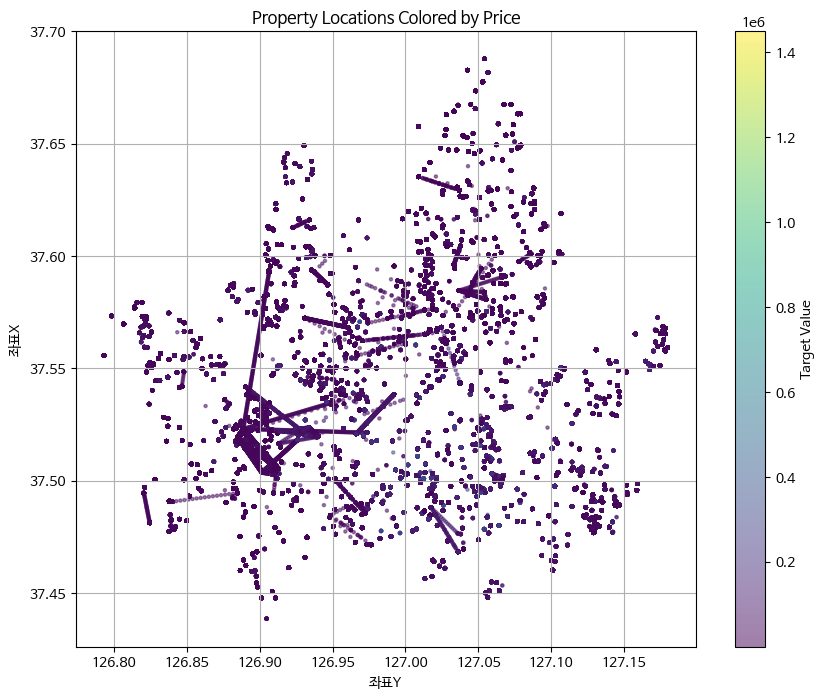

In [141]:
# Add after coordinate swapping to validate
plt.figure(figsize=(10, 8))
plt.scatter(concat_select['좌표Y'], concat_select['좌표X'], 
            alpha=0.5, s=5, c=concat_select['target'], cmap='viridis')
plt.colorbar(label='Target Value')
plt.title('Property Locations Colored by Price')
plt.xlabel('좌표Y')
plt.ylabel('좌표X')
plt.grid(True)
plt.savefig('property_locations.png')
plt.show()

#### Create distance-based features

In [142]:
# Add to your feature engineering section (section 3 in your script)

# Create distance-based features with the corrected coordinates
from math import radians, cos, sin, asin, sqrt

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate the great circle distance between two points in kilometers"""
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Key locations in Seoul (latitude, longitude)
seoul_city_hall = (37.566, 126.978)
gangnam_station = (37.498, 127.028)
seoul_station = (37.556, 126.972)

# Add distance features 
concat_select['dist_to_city_hall'] = concat_select.apply(
    lambda row: haversine_distance(row['좌표Y'], row['좌표X'], 
                                  seoul_city_hall[0], seoul_city_hall[1]), 
    axis=1
)

concat_select['dist_to_gangnam'] = concat_select.apply(
    lambda row: haversine_distance(row['좌표Y'], row['좌표X'], 
                                  gangnam_station[0], gangnam_station[1]), 
    axis=1
)

/tmp/ipykernel_2796498/232657620.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat_select['dist_to_city_hall'] = concat_select.apply(
/tmp/ipykernel_2796498/232657620.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat_select['dist_to_gangnam'] = concat_select.apply(


#### Create Location Clusters

In [143]:
# Add clustering based on location
from sklearn.cluster import KMeans

# Extract coordinates for clustering
coords = concat_select[['좌표X', '좌표Y']].copy()

# Create location clusters
kmeans = KMeans(n_clusters=5, random_state=42)
concat_select['location_cluster'] = kmeans.fit_predict(coords)

In [144]:
# ! pip install --upgrade ipywidgets jupyter
# ! jupyter nbextension enable --py widgetsnbextension
# ! jupyter labextension install @jupyter-widgets/jupyterlab-manager

#### Transportation Features

In [145]:
# %% [markdown]
# #### Transportation Features - High Performance Implementation

# %%
#############################################################
# Transportation Data Integration - Vectorized, Parallelized, Cached
#############################################################
import numpy as np
from scipy.spatial import cKDTree
import multiprocessing as mp
import time
import os
import pickle
from tqdm.notebook import tqdm

def compute_nearest_stations_chunk(args):
    """Worker function for parallel processing"""
    chunk_start, chunk_end, prop_cartesian, station_cartesian, station_data, station_name_col, station_id_col = args
    
    # Build KDTree with station coordinates
    tree = cKDTree(station_cartesian)
    
    # Query the tree for nearest neighbors
    distances, indices = tree.query(prop_cartesian[chunk_start:chunk_end], k=1)
    
    # Convert distances to great circle distance (km)
    earth_radius = 6371  # km
    distances = 2 * earth_radius * np.arcsin(distances / 2)
    
    # Prepare results
    results = {
        'indices': np.arange(chunk_start, chunk_end),
        f'nearest_{station_name_col}_dist': distances,
        f'nearest_{station_name_col}': station_data.iloc[indices][station_name_col].values,
    }
    
    if station_id_col:
        results[f'nearest_{station_id_col}'] = station_data.iloc[indices][station_id_col].values
    
    return results

def compute_transportation_features(properties_df, stations_df, station_type, 
                                    station_name_col, station_id_col=None, 
                                    cache_dir='./cache/XY', use_cache=True,
                                    chunk_size=50000, num_workers=None):
    """
    High-performance computation of nearest station features
    
    Args:
        properties_df: DataFrame with property coordinates
        stations_df: DataFrame with station coordinates
        station_type: Type of station ('subway' or 'bus')
        station_name_col: Column name for station names
        station_id_col: Column name for station IDs/lines
        cache_dir: Directory to store cache files
        use_cache: Whether to use cached results
        chunk_size: Size of chunks for parallel processing
        num_workers: Number of worker processes (default: CPU count - 1)
        
    Returns:
        DataFrame with nearest station features
    """
    # Create cache directory if it doesn't exist
    os.makedirs(cache_dir, exist_ok=True)
    
    # Define cache filename based on input data characteristics
    properties_hash = hash(tuple(properties_df.shape) + 
                          tuple(properties_df['좌표X'].head(10).tolist()) + 
                          tuple(properties_df['좌표Y'].head(10).tolist()))
    stations_hash = hash(tuple(stations_df.shape) + 
                        tuple(stations_df['좌표X'].head(5).tolist()) + 
                        tuple(stations_df['좌표Y'].head(5).tolist()))
    cache_file = os.path.join(cache_dir, f"{station_type}_{properties_hash}_{stations_hash}.pkl")
    
    # Check for cached results
    if use_cache and os.path.exists(cache_file):
        print(f"Loading cached {station_type} features...")
        with open(cache_file, 'rb') as f:
            return pickle.load(f)
    
    start_time = time.time()
    print(f"Computing nearest {station_type} features for {len(properties_df)} properties...")
    
    # Filter out properties with missing coordinates
    valid_mask = ~(properties_df['좌표X'].isna() | properties_df['좌표Y'].isna())
    valid_props = properties_df[valid_mask].copy()
    valid_indices = np.where(valid_mask)[0]
    
    # Convert coordinates to radians
    prop_coords_rad = np.radians(valid_props[['좌표X', '좌표Y']].values)
    station_coords_rad = np.radians(stations_df[['좌표X', '좌표Y']].values)
    
    # Create 3D Cartesian coordinates for KDTree
    prop_x = np.cos(prop_coords_rad[:, 0]) * np.cos(prop_coords_rad[:, 1])
    prop_y = np.cos(prop_coords_rad[:, 0]) * np.sin(prop_coords_rad[:, 1])
    prop_z = np.sin(prop_coords_rad[:, 0])
    prop_cartesian = np.vstack([prop_x, prop_y, prop_z]).T
    
    station_x = np.cos(station_coords_rad[:, 0]) * np.cos(station_coords_rad[:, 1])
    station_y = np.cos(station_coords_rad[:, 0]) * np.sin(station_coords_rad[:, 1])
    station_z = np.sin(station_coords_rad[:, 0])
    station_cartesian = np.vstack([station_x, station_y, station_z]).T
    
    # Determine number of workers
    if num_workers is None:
        num_workers = max(1, mp.cpu_count() - 1)
    
    # Prepare chunks for parallel processing
    n_valid = len(valid_props)
    chunks = [(i, min(i + chunk_size, n_valid), prop_cartesian, 
              station_cartesian, stations_df, station_name_col, station_id_col) 
              for i in range(0, n_valid, chunk_size)]
    
    # Process chunks in parallel
    print(f"Processing in {len(chunks)} chunks using {num_workers} workers...")
    
    # Use multiprocessing for parallel computation
    with mp.Pool(num_workers) as pool:
        chunk_results = list(tqdm(pool.imap(compute_nearest_stations_chunk, chunks), 
                                  total=len(chunks), desc=f"Processing {station_type}"))
    
    # Combine results from all chunks
    combined_results = {}
    for key in chunk_results[0].keys():
        if key == 'indices':
            continue
        combined_results[key] = np.concatenate([chunk['indices'] for chunk in chunk_results]), \
                                np.concatenate([chunk[key] for chunk in chunk_results])
    
    # Create full results array with missing values
    result_cols = [k for k in combined_results.keys()]
    full_results = pd.DataFrame(index=range(len(properties_df)))
    
    # Fill in results for valid properties
    for col in result_cols:
        indices, values = combined_results[col]
        indices_in_full = valid_indices[indices]  # Map back to original dataset indices
        for i, val in zip(indices_in_full, values):
            full_results.loc[i, col] = val
    
    # Reset index to ensure consistency
    full_results = full_results.reset_index(drop=True)
    
    # Cache results
    if use_cache:
        with open(cache_file, 'wb') as f:
            pickle.dump(full_results, f)
    
    print(f"Completed in {time.time() - start_time:.2f} seconds")
    return full_results

# Main processing
print("Starting transportation feature computation...")

# Compute subway features
subway_features = compute_transportation_features(
    concat_select,
    subway_data,
    station_type='subway',
    station_name_col='역사명',
    station_id_col='호선',
    chunk_size=100000,  # Adjust based on available memory
    use_cache=True
)

# Compute bus features
bus_features = compute_transportation_features(
    concat_select,
    bus_data,
    station_type='bus',
    station_name_col='정류소명',
    station_id_col='정류소번호',
    chunk_size=100000,  # Adjust based on available memory
    use_cache=True
)

# Reset index on concat_select to avoid duplication issues
concat_select = concat_select.reset_index(drop=True)

# Join features with main dataset
concat_select = pd.concat([
    concat_select, 
    subway_features, 
    bus_features
], axis=1)

# Fill missing values with median
for col in ['nearest_역사명_dist', 'nearest_정류소명_dist']:
    if col in concat_select.columns:
        median_val = concat_select[col].median()
        concat_select[col] = concat_select[col].fillna(median_val)

# Create additional transportation features
concat_select['has_subway_500m'] = (concat_select['nearest_역사명_dist'] <= 0.5).astype(int)
concat_select['has_bus_500m'] = (concat_select['nearest_정류소명_dist'] <= 0.5).astype(int)
concat_select['transport_score'] = concat_select['has_subway_500m'] * 3 + concat_select['has_bus_500m']

# Create categorized distance features
concat_select['subway_dist_cat'] = pd.cut(
    concat_select['nearest_역사명_dist'], 
    bins=[0, 0.5, 1.0, 2.0, 5.0, float('inf')],
    labels=['0-500m', '500m-1km', '1-2km', '2-5km', '5km+']
)
concat_select['bus_dist_cat'] = pd.cut(
    concat_select['nearest_정류소명_dist'], 
    bins=[0, 0.25, 0.5, 1.0, float('inf')],
    labels=['0-250m', '250-500m', '500m-1km', '1km+']
)

Starting transportation feature computation...
Loading cached subway features...
Loading cached bus features...


In [146]:
# # %% [markdown]
# # #### Transportation Features (Subway & Bus) - Vectorized Approach with Index Fix

# # %%
# #############################################################
# # Transportation Data Integration - Vectorized
# #############################################################
# from scipy.spatial import cKDTree
# import time

# # Function to efficiently find nearest stations using KDTree
# def find_nearest_stations_vectorized(properties_df, stations_df, station_name_col, station_id_col=None):
#     """
#     Vectorized approach to find nearest stations for all properties
    
#     Args:
#         properties_df: DataFrame with property coordinates
#         stations_df: DataFrame with station coordinates
#         station_name_col: Column name for station names
#         station_id_col: Column name for station IDs/lines
        
#     Returns:
#         DataFrame with nearest station info for each property
#     """
#     start_time = time.time()
#     print(f"Finding nearest {station_name_col.split('_')[0] if '_' in station_name_col else station_name_col} for {len(properties_df)} properties...")
    
#     # Filter out properties with missing coordinates
#     valid_mask = ~(properties_df['좌표X'].isna() | properties_df['좌표Y'].isna())
#     valid_props = properties_df[valid_mask].copy()
    
#     # Use position indices instead of DataFrame indices to avoid duplication issues
#     position_indices = np.arange(len(valid_props))
    
#     # Convert coordinates to radians for haversine calculations
#     earth_radius = 6371  # km
#     prop_coords_rad = np.radians(valid_props[['좌표X', '좌표Y']].values)
#     station_coords_rad = np.radians(stations_df[['좌표X', '좌표Y']].values)
    
#     # Create 3D Cartesian coordinates for KDTree
#     # This transforms lat/lon to x,y,z coordinates on a sphere
#     prop_x = np.cos(prop_coords_rad[:, 0]) * np.cos(prop_coords_rad[:, 1])
#     prop_y = np.cos(prop_coords_rad[:, 0]) * np.sin(prop_coords_rad[:, 1])
#     prop_z = np.sin(prop_coords_rad[:, 0])
#     prop_cartesian = np.vstack([prop_x, prop_y, prop_z]).T
    
#     station_x = np.cos(station_coords_rad[:, 0]) * np.cos(station_coords_rad[:, 1])
#     station_y = np.cos(station_coords_rad[:, 0]) * np.sin(station_coords_rad[:, 1])
#     station_z = np.sin(station_coords_rad[:, 0])
#     station_cartesian = np.vstack([station_x, station_y, station_z]).T
    
#     # Build KDTree with station coordinates
#     tree = cKDTree(station_cartesian)
    
#     # Query the tree for nearest neighbor
#     distances, indices = tree.query(prop_cartesian, k=1)
    
#     # Convert distances from chord length to great circle distance
#     distances = 2 * earth_radius * np.arcsin(distances / 2)
    
#     # Create results DataFrame with new index
#     results = pd.DataFrame({
#         f'nearest_{station_name_col}_dist': distances,
#         f'nearest_{station_name_col}': stations_df.iloc[indices][station_name_col].values
#     })
    
#     if station_id_col:
#         results[f'nearest_{station_id_col}'] = stations_df.iloc[indices][station_id_col].values
    
#     # Create a mask array for all properties
#     all_results = pd.DataFrame(index=range(len(properties_df)))
    
#     # Map valid results to their original positions
#     valid_positions = np.where(valid_mask)[0]
#     for i, pos in enumerate(valid_positions):
#         if i < len(results):  # Safety check
#             for col in results.columns:
#                 all_results.loc[pos, col] = results.iloc[i][col]
    
#     print(f"Completed in {time.time() - start_time:.2f} seconds")
#     return all_results.reset_index(drop=True)  # Ensure clean index

# # Process subway data
# subway_features = find_nearest_stations_vectorized(
#     concat_select, 
#     subway_data, 
#     station_name_col='역사명', 
#     station_id_col='호선'
# )

# # Process bus data
# bus_features = find_nearest_stations_vectorized(
#     concat_select, 
#     bus_data, 
#     station_name_col='정류소명', 
#     station_id_col='정류소번호'
# )

# # Reset index on concat_select to avoid duplication issues
# concat_select = concat_select.reset_index(drop=True)

# # Join features with main dataset
# concat_select = pd.concat([
#     concat_select, 
#     subway_features, 
#     bus_features
# ], axis=1)

# # Fill missing values with median
# for col in ['nearest_역사명_dist', 'nearest_정류소명_dist']:
#     if col in concat_select.columns:
#         median_val = concat_select[col].median()
#         concat_select[col] = concat_select[col].fillna(median_val)

# # Create additional transportation features
# concat_select['has_subway_500m'] = (concat_select['nearest_역사명_dist'] <= 0.5).astype(int)
# concat_select['has_bus_500m'] = (concat_select['nearest_정류소명_dist'] <= 0.5).astype(int)
# concat_select['transport_score'] = concat_select['has_subway_500m'] * 3 + concat_select['has_bus_500m']

# # Create categorized distance features
# concat_select['subway_dist_cat'] = pd.cut(
#     concat_select['nearest_역사명_dist'], 
#     bins=[0, 0.5, 1.0, 2.0, 5.0, float('inf')],
#     labels=['0-500m', '500m-1km', '1-2km', '2-5km', '5km+']
# )
# concat_select['bus_dist_cat'] = pd.cut(
#     concat_select['nearest_정류소명_dist'], 
#     bins=[0, 0.25, 0.5, 1.0, float('inf')],
#     labels=['0-250m', '250-500m', '500m-1km', '1km+']
# )

# # Visualize relationship between property price and subway distance
# plt.figure(figsize=(12, 8))

# # Subway distance vs price
# plt.subplot(2, 2, 1)
# sns.scatterplot(
#     x='nearest_역사명_dist', 
#     y='target', 
#     data=concat_select[concat_select['is_test']==0].sample(min(5000, len(concat_select))), 
#     alpha=0.5
# )
# plt.title('Price vs. Distance to Nearest Subway')
# plt.xlabel('Distance (km)')
# plt.ylabel('Price')

# # Subway proximity boxplot
# plt.subplot(2, 2, 2)
# sns.boxplot(
#     x='subway_dist_cat', 
#     y='target', 
#     data=concat_select[concat_select['is_test']==0]
# )
# plt.title('Price by Subway Distance Category')
# plt.xlabel('Distance to Subway')
# plt.ylabel('Price')
# plt.xticks(rotation=45)

# # Bus distance vs price
# plt.subplot(2, 2, 3)
# sns.scatterplot(
#     x='nearest_정류소명_dist', 
#     y='target', 
#     data=concat_select[concat_select['is_test']==0].sample(min(5000, len(concat_select))), 
#     alpha=0.5
# )
# plt.title('Price vs. Distance to Nearest Bus Stop')
# plt.xlabel('Distance (km)')
# plt.ylabel('Price')

# # Transport score boxplot
# plt.subplot(2, 2, 4)
# sns.boxplot(
#     x='transport_score', 
#     y='target', 
#     data=concat_select[concat_select['is_test']==0]
# )
# plt.title('Price by Transportation Score')
# plt.xlabel('Transport Score (0-4)')
# plt.ylabel('Price')

# plt.tight_layout()
# plt.savefig('transportation_analysis.png')
# plt.show()

In [147]:
# # %% [markdown]
# # #### Transportation Features (Subway & Bus) - Vectorized Approach

# # %%
# #############################################################
# # Transportation Data Integration - Vectorized
# #############################################################
# from scipy.spatial import cKDTree
# import time

# # Function to efficiently find nearest stations using KDTree
# def find_nearest_stations_vectorized(properties_df, stations_df, station_name_col, station_id_col=None):
#     """
#     Vectorized approach to find nearest stations for all properties
    
#     Args:
#         properties_df: DataFrame with property coordinates
#         stations_df: DataFrame with station coordinates
#         station_name_col: Column name for station names
#         station_id_col: Column name for station IDs/lines
        
#     Returns:
#         DataFrame with nearest station info for each property
#     """
#     start_time = time.time()
#     print(f"Finding nearest {station_name_col.split('_')[0]} for {len(properties_df)} properties...")
    
#     # Filter out properties with missing coordinates
#     valid_mask = ~(properties_df['좌표X'].isna() | properties_df['좌표Y'].isna())
#     valid_props = properties_df[valid_mask].copy()
#     valid_indices = valid_props.index
    
#     # Convert coordinates to radians for haversine calculations
#     earth_radius = 6371  # km
#     prop_coords_rad = np.radians(valid_props[['좌표X', '좌표Y']].values)
#     station_coords_rad = np.radians(stations_df[['좌표X', '좌표Y']].values)
    
#     # Create 3D Cartesian coordinates for KDTree
#     # This transforms lat/lon to x,y,z coordinates on a sphere
#     prop_x = np.cos(prop_coords_rad[:, 0]) * np.cos(prop_coords_rad[:, 1])
#     prop_y = np.cos(prop_coords_rad[:, 0]) * np.sin(prop_coords_rad[:, 1])
#     prop_z = np.sin(prop_coords_rad[:, 0])
#     prop_cartesian = np.vstack([prop_x, prop_y, prop_z]).T
    
#     station_x = np.cos(station_coords_rad[:, 0]) * np.cos(station_coords_rad[:, 1])
#     station_y = np.cos(station_coords_rad[:, 0]) * np.sin(station_coords_rad[:, 1])
#     station_z = np.sin(station_coords_rad[:, 0])
#     station_cartesian = np.vstack([station_x, station_y, station_z]).T
    
#     # Build KDTree with station coordinates
#     tree = cKDTree(station_cartesian)
    
#     # Query the tree for nearest neighbor
#     distances, indices = tree.query(prop_cartesian, k=1)
    
#     # Convert distances from chord length to great circle distance
#     distances = 2 * earth_radius * np.arcsin(distances / 2)
    
#     # Create results DataFrame for valid properties
#     results = pd.DataFrame(index=valid_indices)
#     results[f'nearest_{station_name_col}_dist'] = distances
#     results[f'nearest_{station_name_col}'] = stations_df.iloc[indices][station_name_col].values
    
#     if station_id_col:
#         results[f'nearest_{station_id_col}'] = stations_df.iloc[indices][station_id_col].values
    
#     # Create full results with NaNs for invalid properties
#     full_results = pd.DataFrame(index=properties_df.index)
#     full_results = full_results.join(results)
    
#     print(f"Completed in {time.time() - start_time:.2f} seconds")
#     return full_results

# # Process subway data
# subway_features = find_nearest_stations_vectorized(
#     concat_select, 
#     subway_data, 
#     station_name_col='역사명', 
#     station_id_col='호선'
# )

# # Process bus data
# bus_features = find_nearest_stations_vectorized(
#     concat_select, 
#     bus_data, 
#     station_name_col='정류소명', 
#     station_id_col='정류소번호'
# )

# # Join features with main dataset
# concat_select = pd.concat([
#     concat_select, 
#     subway_features, 
#     bus_features
# ], axis=1)

# # Fill missing values with median
# for col in ['nearest_역사명_dist', 'nearest_정류소명_dist']:
#     if col in concat_select.columns:
#         median_val = concat_select[col].median()
#         concat_select[col] = concat_select[col].fillna(median_val)

# # Create additional transportation features
# concat_select['has_subway_500m'] = (concat_select['nearest_역사명_dist'] <= 0.5).astype(int)
# concat_select['has_bus_500m'] = (concat_select['nearest_정류소명_dist'] <= 0.5).astype(int)
# concat_select['transport_score'] = concat_select['has_subway_500m'] * 3 + concat_select['has_bus_500m']

# # Create categorized distance features
# concat_select['subway_dist_cat'] = pd.cut(
#     concat_select['nearest_역사명_dist'], 
#     bins=[0, 0.5, 1.0, 2.0, 5.0, float('inf')],
#     labels=['0-500m', '500m-1km', '1-2km', '2-5km', '5km+']
# )
# concat_select['bus_dist_cat'] = pd.cut(
#     concat_select['nearest_정류소명_dist'], 
#     bins=[0, 0.25, 0.5, 1.0, float('inf')],
#     labels=['0-250m', '250-500m', '500m-1km', '1km+']
# )

# # Visualize relationship between property price and subway distance
# plt.figure(figsize=(12, 8))

# # Subway distance vs price
# plt.subplot(2, 2, 1)
# sns.scatterplot(
#     x='nearest_역사명_dist', 
#     y='target', 
#     data=concat_select[concat_select['is_test']==0].sample(min(5000, len(concat_select))), 
#     alpha=0.5
# )
# plt.title('Price vs. Distance to Nearest Subway')
# plt.xlabel('Distance (km)')
# plt.ylabel('Price')

# # Subway proximity boxplot
# plt.subplot(2, 2, 2)
# sns.boxplot(
#     x='subway_dist_cat', 
#     y='target', 
#     data=concat_select[concat_select['is_test']==0]
# )
# plt.title('Price by Subway Distance Category')
# plt.xlabel('Distance to Subway')
# plt.ylabel('Price')
# plt.xticks(rotation=45)

# # Bus distance vs price
# plt.subplot(2, 2, 3)
# sns.scatterplot(
#     x='nearest_정류소명_dist', 
#     y='target', 
#     data=concat_select[concat_select['is_test']==0].sample(min(5000, len(concat_select))), 
#     alpha=0.5
# )
# plt.title('Price vs. Distance to Nearest Bus Stop')
# plt.xlabel('Distance (km)')
# plt.ylabel('Price')

# # Transport score boxplot
# plt.subplot(2, 2, 4)
# sns.boxplot(
#     x='transport_score', 
#     y='target', 
#     data=concat_select[concat_select['is_test']==0]
# )
# plt.title('Price by Transportation Score')
# plt.xlabel('Transport Score (0-4)')
# plt.ylabel('Price')

# plt.tight_layout()
# plt.savefig('transportation_analysis.png')
# plt.show()

In [148]:
# # %% [markdown] LOOP BASED
# # #### Transportation Features (Subway & Bus)

# # %%
# #############################################################
# # Transportation Data Integration
# #############################################################

# # Function to find nearest transportation station/stop
# def find_nearest_station(property_lat, property_lon, stations_df):
#     """Find the nearest station and its distance for a property"""
#     if pd.isna(property_lat) or pd.isna(property_lon):
#         return np.nan, np.nan, np.nan
    
#     # Calculate distances to all stations
#     distances = stations_df.apply(
#         lambda station: haversine_distance(
#             property_lat, property_lon,
#             station['좌표X'], station['좌표Y']
#         ), axis=1
#     )
    
#     # Find the nearest station
#     if len(distances) > 0:
#         min_idx = distances.idxmin()
#         min_distance = distances.min()
#         station_name = stations_df.iloc[min_idx]['역사명' if '역사명' in stations_df.columns else '정류소명']
#         station_line = stations_df.iloc[min_idx]['호선' if '호선' in stations_df.columns else '정류소번호']
#         return min_distance, station_name, station_line
#     else:
#         return np.nan, np.nan, np.nan

# # Calculate distances to nearest subway station
# print("Calculating subway proximity features...")
# subway_features = []

# # Process in batches to avoid memory issues
# batch_size = 10000
# for i in range(0, len(concat_select), batch_size):
#     batch = concat_select.iloc[i:i+batch_size]
#     batch_features = []
    
#     for idx, row in batch.iterrows():
#         distance, station, line = find_nearest_station(
#             row['좌표X'], row['좌표Y'], subway_data
#         )
#         batch_features.append({
#             'nearest_subway_dist': distance,
#             'nearest_subway_station': station,
#             'nearest_subway_line': line
#         })
    
#     subway_features.extend(batch_features)
#     print(f"Processed {min(i+batch_size, len(concat_select))}/{len(concat_select)} properties")

# # Convert to DataFrame and join with main data
# subway_features_df = pd.DataFrame(subway_features)
# concat_select = pd.concat([concat_select.reset_index(drop=True), 
#                            subway_features_df.reset_index(drop=True)], 
#                           axis=1)

# # Calculate distances to nearest bus stop
# print("Calculating bus proximity features...")
# bus_features = []

# # Process in batches
# for i in range(0, len(concat_select), batch_size):
#     batch = concat_select.iloc[i:i+batch_size]
#     batch_features = []
    
#     for idx, row in batch.iterrows():
#         distance, stop_name, stop_id = find_nearest_station(
#             row['좌표X'], row['좌표Y'], bus_data
#         )
#         batch_features.append({
#             'nearest_bus_dist': distance,
#             'nearest_bus_stop': stop_name,
#             'nearest_bus_stop_id': stop_id
#         })
    
#     bus_features.extend(batch_features)
#     print(f"Processed {min(i+batch_size, len(concat_select))}/{len(concat_select)} properties")

# # Convert to DataFrame and join with main data
# bus_features_df = pd.DataFrame(bus_features)
# concat_select = pd.concat([concat_select.reset_index(drop=True), 
#                           bus_features_df.reset_index(drop=True)], 
#                          axis=1)

# # Create additional transportation features
# concat_select['has_subway_500m'] = (concat_select['nearest_subway_dist'] <= 0.5).astype(int)
# concat_select['has_bus_500m'] = (concat_select['nearest_bus_dist'] <= 0.5).astype(int)
# concat_select['transport_score'] = concat_select['has_subway_500m'] * 3 + concat_select['has_bus_500m']

# # Create interaction features
# concat_select['subway_dist_X_building_age'] = concat_select['nearest_subway_dist'] * (2023 - concat_select['건축년도'])
# concat_select['subway_dist_X_area'] = concat_select['nearest_subway_dist'] * concat_select['전용면적']

# # Fill missing values with median
# for col in ['nearest_subway_dist', 'nearest_bus_dist']:
#     concat_select[col] = concat_select[col].fillna(concat_select[col].median())

# # Visualize relationship between property price and subway distance
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# sns.scatterplot(x='nearest_subway_dist', y='target', 
#                 data=concat_select[concat_select['is_test']==0].sample(5000), 
#                 alpha=0.5)
# plt.title('Price vs. Distance to Nearest Subway')
# plt.xlabel('Distance (km)')
# plt.ylabel('Price')

# plt.subplot(1, 2, 2)
# sns.boxplot(x='has_subway_500m', y='target', 
#             data=concat_select[concat_select['is_test']==0])
# plt.title('Price by Subway Proximity')
# plt.xlabel('Within 500m of Subway')
# plt.ylabel('Price')
# plt.tight_layout()
# plt.savefig('subway_price_analysis.png')
# plt.show()

#### Domain-Based Geographic Features

In [149]:
# Add this to your Feature Engineering section (after the existing geographic features)

# 1. Create city, district, neighborhood columns
concat_select[["시", "구", "동"]] = concat_select["시군구"].str.split(" ", expand=True)

# 2. Define lead apartments for each district with their coordinates
import math  # Make sure to add this import at the top

lead_house = {
    "강서구" : (37.56520754904415, 126.82349451366355),
    "관악구" : (37.47800896704934, 126.94178722423047),
    "강남구" : (37.530594054209146, 127.0262701317293),
    "강동구" : (37.557175745977375, 127.16359581113558),
    "광진구" : (37.543083184171, 127.0998363490422),
    "구로구" : (37.51045944660659, 126.88687199829572),
    "금천구" : (37.459818907487936, 126.89741481874103),
    "노원구" : (37.63952738902813, 127.07234254197617),
    "도봉구" : (37.65775043994647, 127.04345013224447),
    "동대문구" : (37.57760781415707, 127.05375628992316),
    "동작구" : (37.509881249641495, 126.9618159122961),
    "마포구" : (37.54341664563958, 126.93601641235335),
    "서대문구" : (37.55808950436837, 126.9559315685538),
    "서초구" : (37.50625410912666, 126.99846468032919),
    "성동구" : (37.53870643389788, 127.04496220606433),
    "성북구" : (37.61158435092128, 127.02699796439015),
    "송파구" : (37.512817775046074, 127.08340371063358),
    "양천구" : (37.526754982736556, 126.86618704123521),
    "영등포구" : (37.52071403351804, 126.93668907644046),
    "용산구" : (37.521223570097305, 126.97345317787784),
    "은평구" : (37.60181702377437, 126.9362806808709),
    "종로구" : (37.56856915384472, 126.96687674967252),
    "중구" : (37.5544678205846, 126.9634879236162),
    "중랑구" : (37.58171824083332, 127.08183326205129),
    "강북구" : (37.61186335979484, 127.02822407466175)
}

# 3. Create lead apartment dataframe
lead_house_data = pd.DataFrame([{"구": k, "대장_좌표X": v[1], "대장_좌표Y": v[0]} for k, v in lead_house.items()])

# 4. Merge with main dataset
concat_select = pd.merge(concat_select, lead_house_data, how="left", on="구")

# 5. Calculate distance to lead apartment
concat_select['대장아파트_거리'] = concat_select.apply(
    lambda row: haversine_distance(row["좌표X"], row["좌표Y"], 
                                  row["대장_좌표Y"], row["대장_좌표X"]) 
    if pd.notnull(row["좌표X"]) and pd.notnull(row["좌표Y"]) 
       and pd.notnull(row["대장_좌표X"]) and pd.notnull(row["대장_좌표Y"]) 
    else np.nan, axis=1
)

# 6. Handle missing values for 대장아파트_거리
# Impute missing values with district median
district_median_distances = concat_select.groupby('구')['대장아파트_거리'].transform('median')
concat_select['대장아파트_거리'] = concat_select['대장아파트_거리'].fillna(district_median_distances)
# For any remaining nulls (if entire district has no distances), fill with overall median
concat_select['대장아파트_거리'] = concat_select['대장아파트_거리'].fillna(concat_select['대장아파트_거리'].median())

# Binary indicator for missing values


# Additional Distance Features
concat_select['대장아파트_거리_결측'] = concat_select[['좌표X', '좌표Y']].isna().any(axis=1).astype(int)
# Calculate distance ranks within each district (1 = closest to lead apartment)
concat_select['대장아파트_거리_순위'] = concat_select.groupby('구')['대장아파트_거리'].rank(ascending=True)

# Create distance bins (close, medium, far)
concat_select['대장아파트_거리_구간'] = pd.qcut(concat_select['대장아파트_거리'], 3, labels=False)

# Create interaction features
concat_select['거리X신축'] = concat_select['대장아파트_거리'] * concat_select['신축여부']



### Enhanced Transportation Feature Engineering

####  1. Distance Bands Instead of Raw Distances

In [150]:
def create_distance_bands(data):
    """Create categorical distance bands that capture non-linear effects"""
    # Subway distance bands
    conditions = [
        (data['nearest_subway_distance'] < 250),
        (data['nearest_subway_distance'] >= 250) & (data['nearest_subway_distance'] < 500),
        (data['nearest_subway_distance'] >= 500) & (data['nearest_subway_distance'] < 1000),
        (data['nearest_subway_distance'] >= 1000) & (data['nearest_subway_distance'] < 2000),
        (data['nearest_subway_distance'] >= 2000)
    ]
    values = ['very_close', 'close', 'walkable', 'distant', 'far']
    data['subway_distance_band'] = np.select(conditions, values, default='far')
    
    # One-hot encode these bands
    subway_bands = pd.get_dummies(data['subway_distance_band'], prefix='subway_band')
    data = pd.concat([data, subway_bands], axis=1)
    
    # Do the same for bus distances with different thresholds
    conditions = [
        (data['nearest_bus_distance'] < 150),
        (data['nearest_bus_distance'] >= 150) & (data['nearest_bus_distance'] < 300),
        (data['nearest_bus_distance'] >= 300) & (data['nearest_bus_distance'] < 600),
        (data['nearest_bus_distance'] >= 600)
    ]
    values = ['very_close', 'close', 'walkable', 'far']
    data['bus_distance_band'] = np.select(conditions, values, default='far')
    
    bus_bands = pd.get_dummies(data['bus_distance_band'], prefix='bus_band')
    data = pd.concat([data, bus_bands], axis=1)
    
    return data

#### 2. Neighborhood-Specific Transit Value

In [151]:
def create_neighborhood_transit_features(data):
    """Create features that capture how transit value differs by neighborhood"""
    # Calculate average price per neighborhood (구 or district)
    neighborhood_avg_price = data.groupby('구')['target'].transform('mean')
    data['neighborhood_price_level'] = pd.qcut(neighborhood_avg_price, 4, 
                                             labels=['low', 'medium', 'high', 'premium'])
    
    # Create interaction between neighborhood quality and transit proximity
    # Create interaction features for high-value vs low-value neighborhoods
    data['premium_area_near_subway'] = ((data['neighborhood_price_level'] == 'premium') & 
                                      (data['nearest_subway_distance'] < 500)).astype(int)
    
    data['low_value_area_near_subway'] = ((data['neighborhood_price_level'] == 'low') & 
                                        (data['nearest_subway_distance'] < 500)).astype(int)
    
    # Create similar features for bus proximity
    data['premium_area_near_bus'] = ((data['neighborhood_price_level'] == 'premium') & 
                                   (data['nearest_bus_distance'] < 300)).astype(int)
    
    data['low_value_area_near_bus'] = ((data['neighborhood_price_level'] == 'low') & 
                                     (data['nearest_bus_distance'] < 300)).astype(int)
    
    return data

#### 3. Transit Line Importance

In [152]:
def add_subway_line_importance(data, subway_data):
    """Add features reflecting the importance of different subway lines"""
    # Define subway line importance (you would customize this for your city)
    # For Seoul, lines 1-4 are older and serve central areas, line 9 is newer and serves business areas
    line_importance = {
        '1호선': 5,  # Main line
        '2호선': 5,  # Circle line, very important
        '3호선': 4,
        '4호선': 4,
        '5호선': 3,
        '6호선': 3,
        '7호선': 3,
        '8호선': 3,
        '9호선': 4,  # Express line
    }
    
    # Default value for other lines
    default_importance = 2
    
    # Add line importance to the data
    data['subway_line_importance'] = data['nearest_subway_line'].map(
        lambda x: line_importance.get(x, default_importance)
    )
    
    # Create features combining line importance and distance
    data['subway_value_score'] = data['subway_line_importance'] * (
        1000 / (data['nearest_subway_distance'] + 100)  # Add 100 to avoid division by zero
    )
    
    # Create categorical version
    data['subway_value_category'] = pd.qcut(data['subway_value_score'], 4, 
                                          labels=['low', 'medium', 'high', 'premium'])
    
    return data

#### 4. Property-Specific Transit Interaction

In [153]:
def create_property_transit_interactions(data):
    """Create features that capture interactions between property attributes and transit"""
    # How transit affects different property sizes differently
    # Small apartments might benefit more from transit access
    data['small_apt_near_subway'] = ((data['전용면적'] < 60) & 
                                   (data['nearest_subway_distance'] < 500)).astype(int)
    
    data['large_apt_near_subway'] = ((data['전용면적'] > 100) & 
                                   (data['nearest_subway_distance'] < 500)).astype(int)
    
    # How transit affects properties of different ages
    data['new_building_near_subway'] = ((data['건축년도'] > 2010) & 
                                      (data['nearest_subway_distance'] < 500)).astype(int)
    
    data['old_building_near_subway'] = ((data['건축년도'] < 2000) & 
                                      (data['nearest_subway_distance'] < 500)).astype(int)
    
    # High floor + good transit = premium combination
    data['high_floor_near_transit'] = ((data['층'] > 10) & 
                                     (data['nearest_subway_distance'] < 800)).astype(int)
    
    return data

#### 5. Transit Network Connectivity

In [154]:
def calculate_transit_connectivity(data):
    """Calculate features related to transit network connectivity"""
    # Basic connectivity score (multiple stations nearby)
    data['subway_connectivity'] = data['subway_stations_500m'] + data['subway_stations_1km'] * 0.5
    
    # Multi-modal connectivity (both subway and bus)
    data['multimodal_access'] = ((data['nearest_subway_distance'] < 800) & 
                               (data['nearest_bus_distance'] < 400)).astype(int)
    
    # Transit richness: more lines/routes = better connectivity
    # This is a weighted score of transit options
    data['transit_richness'] = (
        data['subway_stations_1km'] * 2 +  # Subway stations count double
        data['bus_stops_500m'] * 0.5       # Bus stops count half
    )
    
    # Simplify into a categorical feature
    data['transit_richness_category'] = pd.qcut(
        data['transit_richness'].clip(lower=0, upper=data['transit_richness'].quantile(0.99)), 
        4, labels=['poor', 'basic', 'good', 'excellent']
    )
    
    return data

#### 6. Coordinate-Based Features

In [155]:
def add_coordinate_based_features(data):
    """Add features based on coordinates and their relationship to transit"""
    # Create distance from center of city (approximate for Seoul)
    # City center coordinates for Seoul (City Hall)
    city_center_lat = 37.566  
    city_center_lon = 126.978
    
    # Calculate distance to city center
    data['dist_to_city_center'] = np.sqrt(
        (data['좌표Y'] - city_center_lat)**2 + 
        (data['좌표X'] - city_center_lon)**2
    ) * 111000  # Convert to meters (rough approximation)
    
    # Transit accessibility relative to distance from center
    # Properties far from center with good transit should have premium
    data['remote_with_good_transit'] = ((data['dist_to_city_center'] > 10000) & 
                                      (data['nearest_subway_distance'] < 800)).astype(int)
    
    # Properties near center with poor transit should have discount
    data['central_poor_transit'] = ((data['dist_to_city_center'] < 5000) & 
                                  (data['nearest_subway_distance'] > 1500)).astype(int)
    
    return data

#### 7. Refined Transit Score

In [156]:
def calculate_refined_transit_score(data):
    """Calculate a more sophisticated transit score"""
    # Base score components
    subway_score = np.clip(10 - (data['nearest_subway_distance'] / 250), 0, 10)
    bus_score = np.clip(5 - (data['nearest_bus_distance'] / 200), 0, 5)
    
    # Line importance factor
    line_factor = data.get('subway_line_importance', 3) / 3
    
    # Density factor (more stations = better connectivity)
    density_factor = np.clip(1 + (data['subway_stations_1km'] / 5), 1, 2)
    
    # Apply neighborhood adjustment
    neighborhood_factor = 1.0
    if 'neighborhood_price_level' in data.columns:
        # Apply different weights based on neighborhood tier
        neighborhood_map = {'low': 0.8, 'medium': 1.0, 'high': 1.2, 'premium': 1.5}
        neighborhood_factor = data['neighborhood_price_level'].map(neighborhood_map).fillna(1.0)
    
    # Calculate final score
    data['refined_transit_score'] = (
        (subway_score * line_factor * density_factor * 0.7) +  # 70% weight to subway
        (bus_score * 0.3)  # 30% weight to bus
    ) * neighborhood_factor  # Adjust by neighborhood
    
    return data

### 8. Implementation of the features in the Pipeline

In [157]:
def enhance_transportation_features(data, subway_data, bus_data):
    """Apply all transportation feature enhancements"""
    # First make sure we have the basic transportation features
    if 'nearest_subway_distance' not in data.columns:
        print("Basic transportation features missing. Skipping enhancements.")
        return data
    
    # Apply each enhancement
    data = create_distance_bands(data)
    data = create_neighborhood_transit_features(data)
    data = add_subway_line_importance(data, subway_data)
    data = create_property_transit_interactions(data)
    data = calculate_transit_connectivity(data)
    data = add_coordinate_based_features(data)
    data = calculate_refined_transit_score(data)
    
    # Print summary of new features
    new_features = [col for col in data.columns if 'transit' in col or 'subway' in col or 'bus' in col]
    print(f"Created {len(new_features)} enhanced transportation features")
    
    return data

#### # After adding basic transportation features

In [158]:
# After adding basic transportation features
if any('transit' in col for col in concat_select.columns):
    print("\nEnhancing transportation features...")
    concat_select = enhance_transportation_features(concat_select, subway_data, bus_data)

#### 4. DATA SPLITTING: (STRATIFIED K-FOLD IMPLEMENTATION)

In [159]:
#############################################################
# 4. DATA SPLITTING
#############################################################
# Split back into train and test
train_data = concat_select[concat_select['is_test'] == 0]
test_data = concat_select[concat_select['is_test'] == 1]

# Create feature and target variables
X_train = train_data.drop(['target', 'is_test'], axis=1)
y_train = train_data['target']
X_test = test_data.drop(['target', 'is_test'], axis=1, errors='ignore')

# For stratified k-fold, we need to create bins of the target variable
def create_target_bins(y, n_bins=10):
    """Create bins from continuous target for stratification"""
    return pd.qcut(y, q=n_bins, labels=False, duplicates='drop')

# Create target bins for stratification
target_bins = create_target_bins(y_train)

# Initialize stratified k-fold
from sklearn.model_selection import StratifiedKFold
n_folds = 2                                                                       #   < ---            K-fold 수
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Lists to store fold indices for later use
fold_indices = []
for train_idx, val_idx in skf.split(X_train, target_bins):
    fold_indices.append((train_idx, val_idx))

print(f"Data prepared for {n_folds}-fold cross-validation")



Data prepared for 2-fold cross-validation


#### Visualization

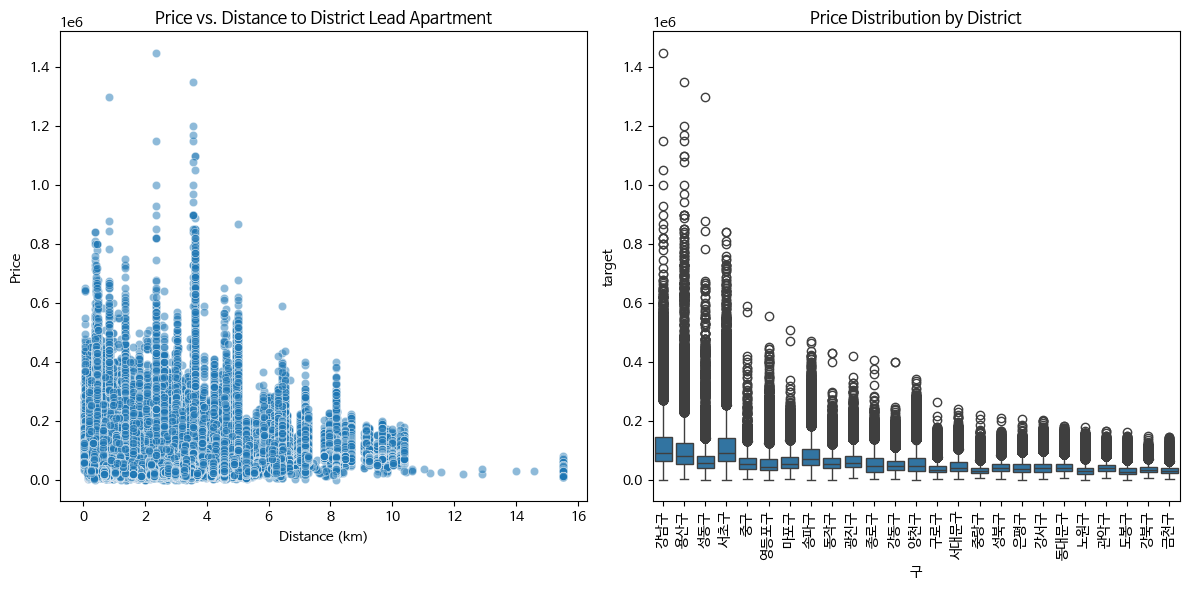

In [160]:
# Add after feature engineering and before model training
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='대장아파트_거리', y='target', data=train_data, alpha=0.5)
plt.title('Price vs. Distance to District Lead Apartment')
plt.xlabel('Distance (km)')
plt.ylabel('Price')

plt.subplot(1, 2, 2)
sns.boxplot(x='구', y='target', data=train_data.sort_values('target', ascending=False))
plt.xticks(rotation=90)
plt.title('Price Distribution by District')
plt.tight_layout()
plt.savefig('lead_apartment_analysis.png')
plt.show()

#### 5. PREPROCESSING PIPELINE

In [161]:
# #############################################################
# # 5. PREPROCESSING PIPELINE(Modified for Stratified K-fold)
# #############################################################
# Update categorical and continuous columns lists after feature engineering
categorical_columns = [col for col in X_train.columns if not pd.api.types.is_numeric_dtype(X_train[col])]
continuous_columns = [col for col in X_train.columns if pd.api.types.is_numeric_dtype(X_train[col])]

print(f"Continuous columns: {len(continuous_columns)}")
print(f"Categorical columns: {len(categorical_columns)}")

# Function to preprocess data for a specific fold
def preprocess_fold_data(X_train_fold, y_train_fold, X_val_fold, y_val_fold, X_test=None):
    """Preprocess data for a single fold, including feature scaling and encoding"""
    # Get original scale values for later evaluation
    y_train_fold_orig = y_train_fold.copy()
    y_val_fold_orig = y_val_fold.copy() if y_val_fold is not None else None
    
    # Apply log transformation to target
    min_val = min(y_train_fold.min(), y_val_fold.min() if y_val_fold is not None else float('inf'))
    offset = abs(min_val) + 1 if min_val <= 0 else 0
    
    y_train_fold_log = np.log1p(y_train_fold + offset)
    y_val_fold_log = np.log1p(y_val_fold + offset) if y_val_fold is not None else None
    
    # Make copies to avoid modifying originals
    X_train_fold = X_train_fold.copy()
    X_val_fold = X_val_fold.copy() if X_val_fold is not None else None
    X_test_fold = X_test.copy() if X_test is not None else None
    
    # Scale features
    feature_scaler = RobustScaler()
    X_train_fold.loc[:, continuous_columns] = feature_scaler.fit_transform(X_train_fold[continuous_columns])
    
    if X_val_fold is not None:
        X_val_fold.loc[:, continuous_columns] = feature_scaler.transform(X_val_fold[continuous_columns])
    
    if X_test_fold is not None:
        X_test_fold.loc[:, continuous_columns] = feature_scaler.transform(X_test_fold[continuous_columns])
    
    # Encode categorical features
    label_encoders = {}
    for col in categorical_columns:
        lbl = LabelEncoder()
        
        # Determine which datasets to include when fitting the encoder
        datasets_to_fit = [X_train_fold[col]]
        if X_val_fold is not None:
            datasets_to_fit.append(X_val_fold[col])
        if X_test_fold is not None:
            datasets_to_fit.append(X_test_fold[col])
        
        # Fit on combined data to handle all categories
        all_values = pd.concat(datasets_to_fit).astype(str).unique()
        lbl.fit(all_values)
        
        # Transform each dataset
        X_train_fold.loc[:, col] = lbl.transform(X_train_fold[col].astype(str))
        
        if X_val_fold is not None:
            X_val_fold.loc[:, col] = lbl.transform(X_val_fold[col].astype(str))
        
        if X_test_fold is not None:
            X_test_fold.loc[:, col] = lbl.transform(X_test_fold[col].astype(str))
        
        label_encoders[col] = lbl
    
    # Return all processed data and transformation parameters
    result = {
        'X_train': X_train_fold,
        'y_train_log': y_train_fold_log,
        'y_train_orig': y_train_fold_orig,
        'feature_scaler': feature_scaler,
        'label_encoders': label_encoders,
        'offset': offset
    }
    
    if X_val_fold is not None:
        result.update({
            'X_val': X_val_fold,
            'y_val_log': y_val_fold_log,
            'y_val_orig': y_val_fold_orig
        })
    
    if X_test_fold is not None:
        result['X_test'] = X_test_fold
        
    return result

print("Preprocessing pipeline prepared")


Continuous columns: 34
Categorical columns: 38
Preprocessing pipeline prepared


#### 6. MODEL TRAINING

Starting 2-fold cross-validation...

Fold 1/2


/tmp/ipykernel_2796498/4201564893.py:32: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_train_fold.loc[:, continuous_columns] = feature_scaler.fit_transform(X_train_fold[continuous_columns])
/tmp/ipykernel_2796498/4201564893.py:35: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_val_fold.loc[:, continuous_columns] = feature_scaler.transform(X_val_fold[continuous_columns])
/tmp/ipykernel_2796498/4201564893.py:57: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setti

[0]	validation_0-rmse:9.75800	validation_1-rmse:9.75796
[100]	validation_0-rmse:0.17884	validation_1-rmse:0.17979
[200]	validation_0-rmse:0.14594	validation_1-rmse:0.14766
[300]	validation_0-rmse:0.13390	validation_1-rmse:0.13613
[400]	validation_0-rmse:0.12553	validation_1-rmse:0.12824
[500]	validation_0-rmse:0.11948	validation_1-rmse:0.12264
[600]	validation_0-rmse:0.11445	validation_1-rmse:0.11801
[700]	validation_0-rmse:0.11006	validation_1-rmse:0.11401
[800]	validation_0-rmse:0.10666	validation_1-rmse:0.11093
[900]	validation_0-rmse:0.10356	validation_1-rmse:0.10821
[1000]	validation_0-rmse:0.10073	validation_1-rmse:0.10575
[1100]	validation_0-rmse:0.09813	validation_1-rmse:0.10350
[1200]	validation_0-rmse:0.09603	validation_1-rmse:0.10172
[1300]	validation_0-rmse:0.09405	validation_1-rmse:0.10008
[1400]	validation_0-rmse:0.09215	validation_1-rmse:0.09852
[1500]	validation_0-rmse:0.09051	validation_1-rmse:0.09720
[1600]	validation_0-rmse:0.08903	validation_1-rmse:0.09602
[1700]	va

/tmp/ipykernel_2796498/4201564893.py:32: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_train_fold.loc[:, continuous_columns] = feature_scaler.fit_transform(X_train_fold[continuous_columns])
/tmp/ipykernel_2796498/4201564893.py:35: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_val_fold.loc[:, continuous_columns] = feature_scaler.transform(X_val_fold[continuous_columns])
/tmp/ipykernel_2796498/4201564893.py:57: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setti

[0]	validation_0-rmse:9.75797	validation_1-rmse:9.75802
[100]	validation_0-rmse:0.17947	validation_1-rmse:0.18012
[200]	validation_0-rmse:0.14683	validation_1-rmse:0.14789
[300]	validation_0-rmse:0.13413	validation_1-rmse:0.13558
[400]	validation_0-rmse:0.12625	validation_1-rmse:0.12804
[500]	validation_0-rmse:0.12019	validation_1-rmse:0.12238
[600]	validation_0-rmse:0.11511	validation_1-rmse:0.11771
[700]	validation_0-rmse:0.11101	validation_1-rmse:0.11392
[800]	validation_0-rmse:0.10740	validation_1-rmse:0.11068
[900]	validation_0-rmse:0.10429	validation_1-rmse:0.10792
[1000]	validation_0-rmse:0.10168	validation_1-rmse:0.10563
[1100]	validation_0-rmse:0.09902	validation_1-rmse:0.10337
[1200]	validation_0-rmse:0.09678	validation_1-rmse:0.10144
[1300]	validation_0-rmse:0.09488	validation_1-rmse:0.09990
[1400]	validation_0-rmse:0.09324	validation_1-rmse:0.09851
[1500]	validation_0-rmse:0.09157	validation_1-rmse:0.09718
[1600]	validation_0-rmse:0.09000	validation_1-rmse:0.09593
[1700]	va

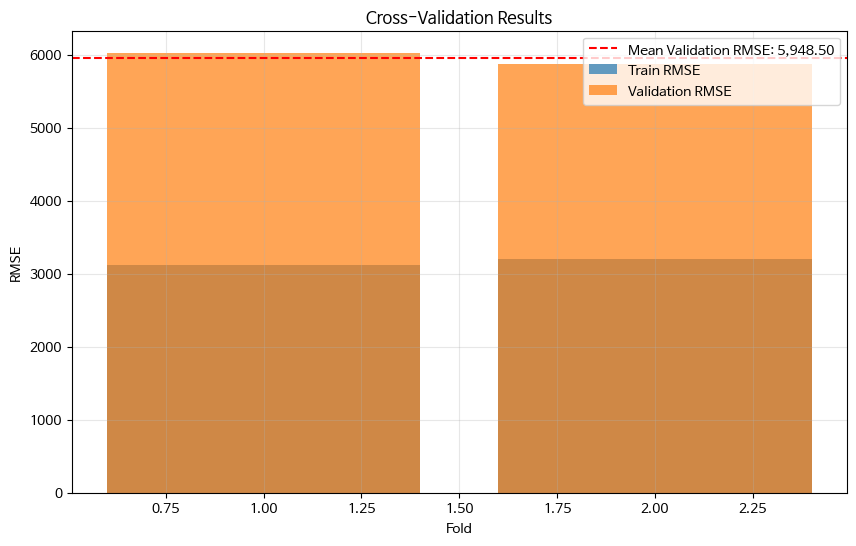

In [162]:
#############################################################
# 6. MODEL TRAINING (Stratified K-fold)
#############################################################

# Lists to store fold results
cv_train_rmse = []
cv_val_rmse = []
cv_models = []

# Perform cross-validation
print(f"Starting {n_folds}-fold cross-validation...")

for fold, (train_idx, val_idx) in enumerate(fold_indices):
    print(f"\nFold {fold+1}/{n_folds}")
    
    # Split data for this fold
    X_train_fold = X_train.iloc[train_idx]
    y_train_fold = y_train.iloc[train_idx]
    X_val_fold = X_train.iloc[val_idx]
    y_val_fold = y_train.iloc[val_idx]
    
    # Preprocess data for this fold
    fold_data = preprocess_fold_data(X_train_fold, y_train_fold, X_val_fold, y_val_fold)

    # Define XGBoost model
    model_fold  = XGBRegressor(
        n_estimators=100000,
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        early_stopping_rounds=100,
        reg_alpha=0.001,
        reg_lambda=0,
        random_state=42,
        tree_method='gpu_hist' if xgb.config.get_config().get('use_gpu', False) else 'hist',
        predictor='gpu_predictor',  
    )


    # Train the model
    model_fold.fit(
        fold_data['X_train'], fold_data['y_train_log'],
        eval_set=[(fold_data['X_train'], fold_data['y_train_log']), 
                  (fold_data['X_val'], fold_data['y_val_log'])],
        verbose=100
    )
    
    # Save trained model and preprocessing info
    cv_models.append({
        'model': model_fold,
        'feature_scaler': fold_data['feature_scaler'],
        'label_encoders': fold_data['label_encoders'],
        'offset': fold_data['offset']
    })
    
    # Make predictions
    train_pred_log = model_fold.predict(fold_data['X_train'])
    val_pred_log = model_fold.predict(fold_data['X_val'])
    
    # Convert to original scale
    train_pred_orig = np.expm1(train_pred_log) - fold_data['offset']
    val_pred_orig = np.expm1(val_pred_log) - fold_data['offset']
    
    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(fold_data['y_train_orig'], train_pred_orig))
    val_rmse = np.sqrt(mean_squared_error(fold_data['y_val_orig'], val_pred_orig))
    
    # Store results
    cv_train_rmse.append(train_rmse)
    cv_val_rmse.append(val_rmse)
    
    # Print results for this fold
    print(f"Fold {fold+1} Train RMSE: {train_rmse:,.2f}")
    print(f"Fold {fold+1} Validation RMSE: {val_rmse:,.2f}")

# Find best model (based on validation RMSE)
best_model_idx = np.argmin(cv_val_rmse)
best_model_info = cv_models[best_model_idx]

# Print overall cross-validation results
print("\nCross-Validation Results:")
print(f"Average Train RMSE: {np.mean(cv_train_rmse):,.2f} (±{np.std(cv_train_rmse):,.2f})")
print(f"Average Validation RMSE: {np.mean(cv_val_rmse):,.2f} (±{np.std(cv_val_rmse):,.2f})")
print(f"Best model from fold {best_model_idx+1} with validation RMSE: {cv_val_rmse[best_model_idx]:,.2f}")

# Visualize cross-validation results
plt.figure(figsize=(10, 6))
plt.bar(range(1, n_folds+1), cv_train_rmse, alpha=0.7, label='Train RMSE')
plt.bar(range(1, n_folds+1), cv_val_rmse, alpha=0.7, label='Validation RMSE')
plt.axhline(y=np.mean(cv_val_rmse), color='r', linestyle='--', 
            label=f'Mean Validation RMSE: {np.mean(cv_val_rmse):,.2f}')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('Cross-Validation Results')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('cv_results.png')
plt.show()

#### Plot learning curves

#### 7. MODEL EVALUATION


=== Cross-Validation Performance Analysis ===
Average Train RMSE: 3,160.54 (±45.50)
Average Validation RMSE: 5,948.50 (±76.99)
Best model from fold 2 with validation RMSE: 5,871.51
Train RMSE coefficient of variation: 1.44%
Validation RMSE coefficient of variation: 1.29%


/tmp/ipykernel_2796498/1558082448.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([cv_train_rmse, cv_val_rmse], labels=['Train RMSE', 'Validation RMSE'])


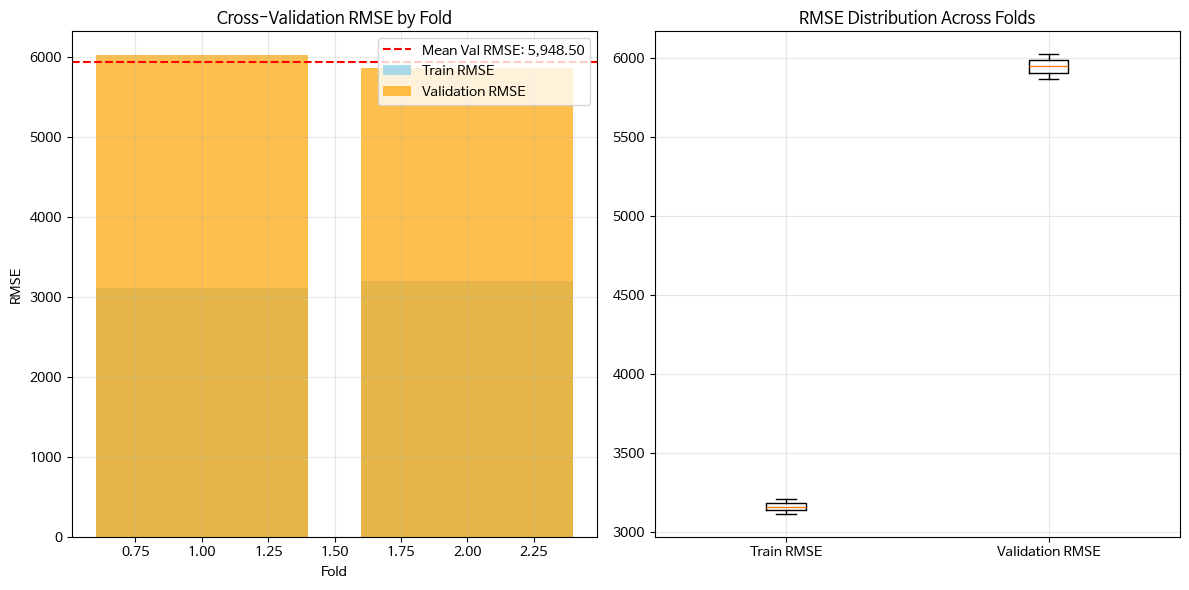


=== Best Model Analysis ===


/tmp/ipykernel_2796498/4201564893.py:32: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_train_fold.loc[:, continuous_columns] = feature_scaler.fit_transform(X_train_fold[continuous_columns])
/tmp/ipykernel_2796498/4201564893.py:35: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_val_fold.loc[:, continuous_columns] = feature_scaler.transform(X_val_fold[continuous_columns])
/tmp/ipykernel_2796498/4201564893.py:57: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setti

Best model Train RMSE: 3,206.03
Best model Validation RMSE: 5,871.51


/tmp/ipykernel_2796498/1558082448.py:101: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
/tmp/ipykernel_2796498/1558082448.py:102: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.savefig('best_model_analysis.png')
/data/ephemeral/home/miniconda3/envs/py39-rapids-env1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


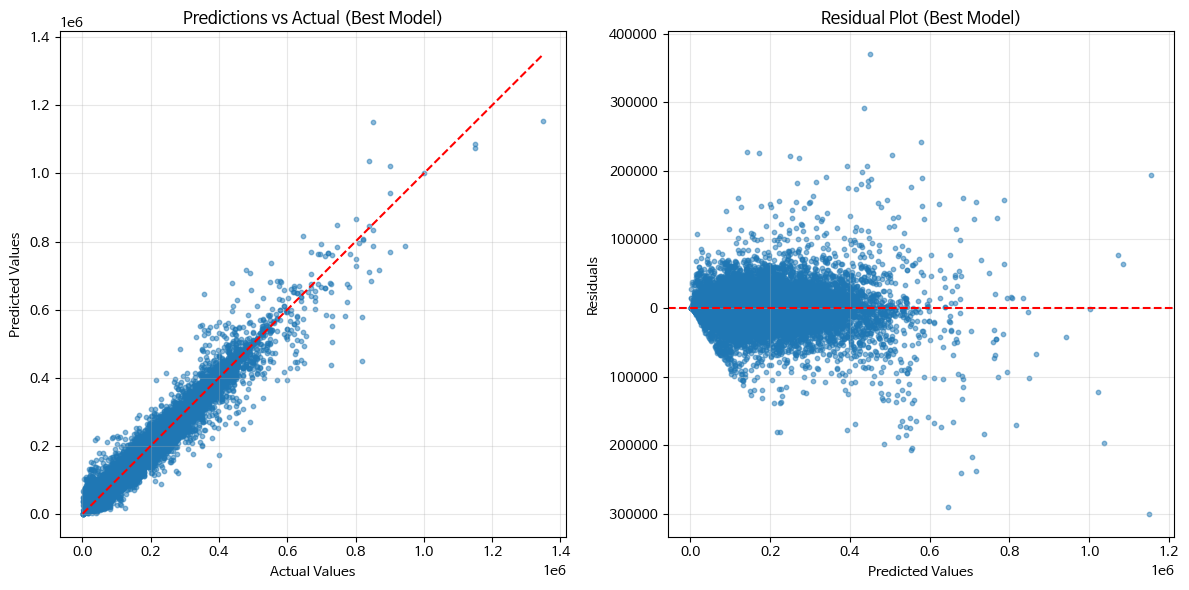


=== Feature Importance Analysis ===
Top 10 Most Important Features:
              Feature  Importance
50   location_cluster    0.298253
47               신축여부    0.118021
66             대장_좌표Y    0.075544
56      nearest_정류소번호    0.057306
16             k-난방방식    0.046844
5                전용면적    0.042222
49    dist_to_gangnam    0.031236
44                계약년    0.028791
65             대장_좌표X    0.024890
48  dist_to_city_hall    0.024380


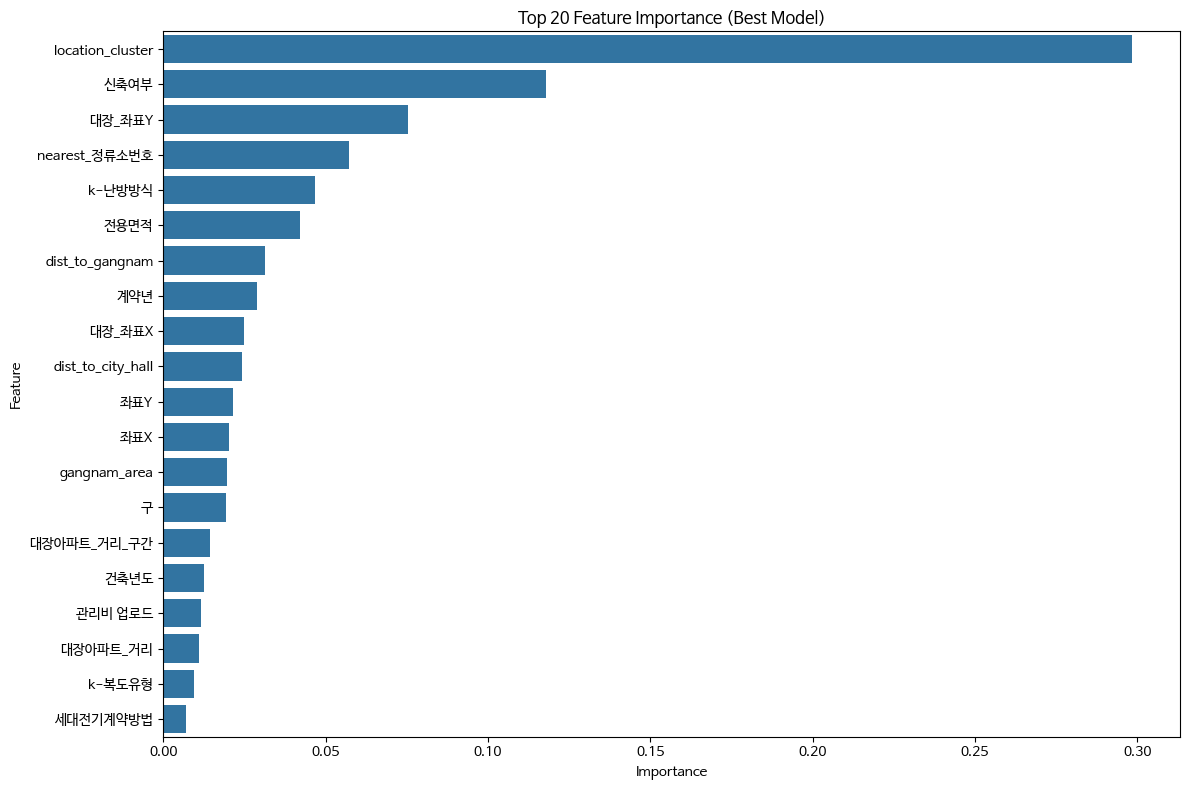

Number of features needed for 90% of total importance: 21


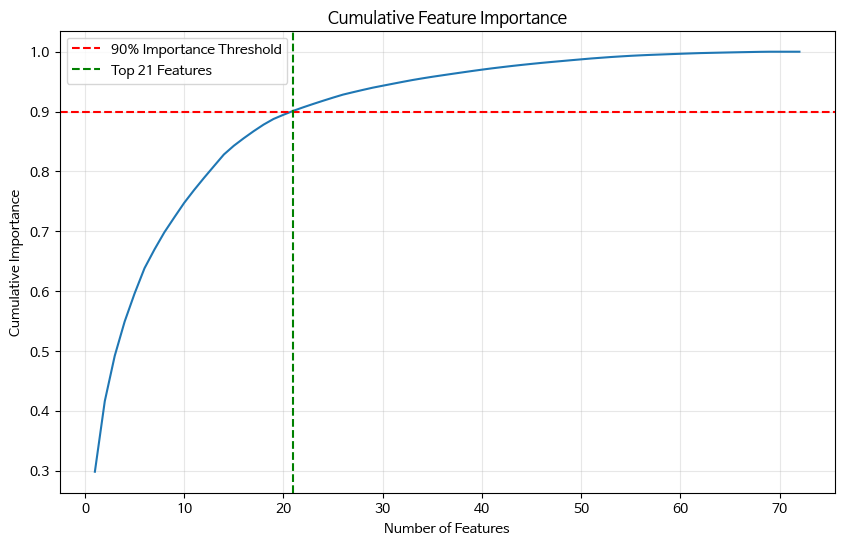

In [163]:
# We'll focus on two key evaluations:
# 1. Overall cross-validation performance analysis
# 2. Detailed analysis of the best model from cross-validation

# 7.1 Cross-Validation Performance Analysis
print("\n=== Cross-Validation Performance Analysis ===")

# Calculate average and std dev of CV results
mean_train_rmse = np.mean(cv_train_rmse)
std_train_rmse = np.std(cv_train_rmse)
mean_val_rmse = np.mean(cv_val_rmse)
std_val_rmse = np.std(cv_val_rmse)

# Print summary statistics
print(f"Average Train RMSE: {mean_train_rmse:,.2f} (±{std_train_rmse:,.2f})")
print(f"Average Validation RMSE: {mean_val_rmse:,.2f} (±{std_val_rmse:,.2f})")
print(f"Best model from fold {best_model_idx+1} with validation RMSE: {cv_val_rmse[best_model_idx]:,.2f}")

# Calculate the coefficient of variation (CV) to assess stability
cv_train = std_train_rmse / mean_train_rmse * 100
cv_val = std_val_rmse / mean_val_rmse * 100
print(f"Train RMSE coefficient of variation: {cv_train:.2f}%")
print(f"Validation RMSE coefficient of variation: {cv_val:.2f}%")

# Visualize cross-validation results as bar chart
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(1, n_folds+1), cv_train_rmse, alpha=0.7, label='Train RMSE', color='skyblue')
plt.bar(range(1, n_folds+1), cv_val_rmse, alpha=0.7, label='Validation RMSE', color='orange')
plt.axhline(y=mean_val_rmse, color='r', linestyle='--', 
            label=f'Mean Val RMSE: {mean_val_rmse:,.2f}')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('Cross-Validation RMSE by Fold')
plt.legend()
plt.grid(True, alpha=0.3)

# Visualize train vs validation RMSE distribution as boxplot
plt.subplot(1, 2, 2)
plt.boxplot([cv_train_rmse, cv_val_rmse], labels=['Train RMSE', 'Validation RMSE'])
plt.title('RMSE Distribution Across Folds')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('cv_performance_analysis.png')
plt.show()

# 7.2 Best Model Analysis
print("\n=== Best Model Analysis ===")

# Get the best model and its parameters
best_model = best_model_info['model']
best_feature_scaler = best_model_info['feature_scaler']
best_label_encoders = best_model_info['label_encoders']
best_offset = best_model_info['offset']

# Get train and validation indices for the best fold
best_train_idx, best_val_idx = fold_indices[best_model_idx]
X_best_train = X_train.iloc[best_train_idx]
y_best_train = y_train.iloc[best_train_idx]
X_best_val = X_train.iloc[best_val_idx]
y_best_val = y_train.iloc[best_val_idx]

# Reapply preprocessing to get proper evaluation data
best_fold_data = preprocess_fold_data(X_best_train, y_best_train, X_best_val, y_best_val)

# Make predictions with the best model
best_train_pred_log = best_model.predict(best_fold_data['X_train'])
best_val_pred_log = best_model.predict(best_fold_data['X_val'])

# Convert to original scale
best_train_pred_orig = np.expm1(best_train_pred_log) - best_offset
best_val_pred_orig = np.expm1(best_val_pred_log) - best_offset

# Calculate final RMSE on best model's fold
best_train_rmse = np.sqrt(mean_squared_error(best_fold_data['y_train_orig'], best_train_pred_orig))
best_val_rmse = np.sqrt(mean_squared_error(best_fold_data['y_val_orig'], best_val_pred_orig))
print(f"Best model Train RMSE: {best_train_rmse:,.2f}")
print(f"Best model Validation RMSE: {best_val_rmse:,.2f}")

# Plot actual vs predicted for validation set
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(best_fold_data['y_val_orig'], best_val_pred_orig, alpha=0.5, s=10)
plt.plot([best_fold_data['y_val_orig'].min(), best_fold_data['y_val_orig'].max()], 
         [best_fold_data['y_val_orig'].min(), best_fold_data['y_val_orig'].max()], 
         'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual (Best Model)')
plt.grid(True, alpha=0.3)

# Plot residuals
residuals = best_fold_data['y_val_orig'] - best_val_pred_orig
plt.subplot(1, 2, 2)
plt.scatter(best_val_pred_orig, residuals, alpha=0.5, s=10)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Best Model)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('best_model_analysis.png')
plt.show()

# 7.3 Feature Importance Analysis
print("\n=== Feature Importance Analysis ===")

# Get feature importance from best model
importance = best_model.feature_importances_
feature_names = best_fold_data['X_train'].columns

# Create DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Print top 10 features
print("Top 10 Most Important Features:")
print(importance_df.head(10))

# Plot top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importance (Best Model)')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

# Calculate cumulative importance
importance_df['Cumulative_Importance'] = importance_df['Importance'].cumsum()
num_features_90pct = sum(importance_df['Cumulative_Importance'] <= 0.9) + 1
print(f"Number of features needed for 90% of total importance: {num_features_90pct}")

# Cumulative importance plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(importance_df) + 1), importance_df['Cumulative_Importance'])
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Importance Threshold')
plt.axvline(x=num_features_90pct, color='g', linestyle='--', 
            label=f'Top {num_features_90pct} Features')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('cumulative_importance.png')
plt.show()

#### 7.1 ERROR ANALYSIS VISUALIZATION


=== Error Analysis Visualization ===
=== Error Statistics ===
Mean Absolute Error: 2,653.61
Median Absolute Error: 1,373.10
Mean Percentage Error: 4.67%
Median Percentage Error: 3.11%
Overpredictions: 270579 (32.2%)
Underpredictions: 288829 (34.4%)


/tmp/ipykernel_2796498/1362567428.py:85: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=['Worst 100 Predictions', 'Best 100 Predictions'])
/tmp/ipykernel_2796498/1362567428.py:101: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
/tmp/ipykernel_2796498/1362567428.py:102: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.savefig('error_analysis.png')
/data/ephemeral/home/miniconda3/envs/py39-rapids-env1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


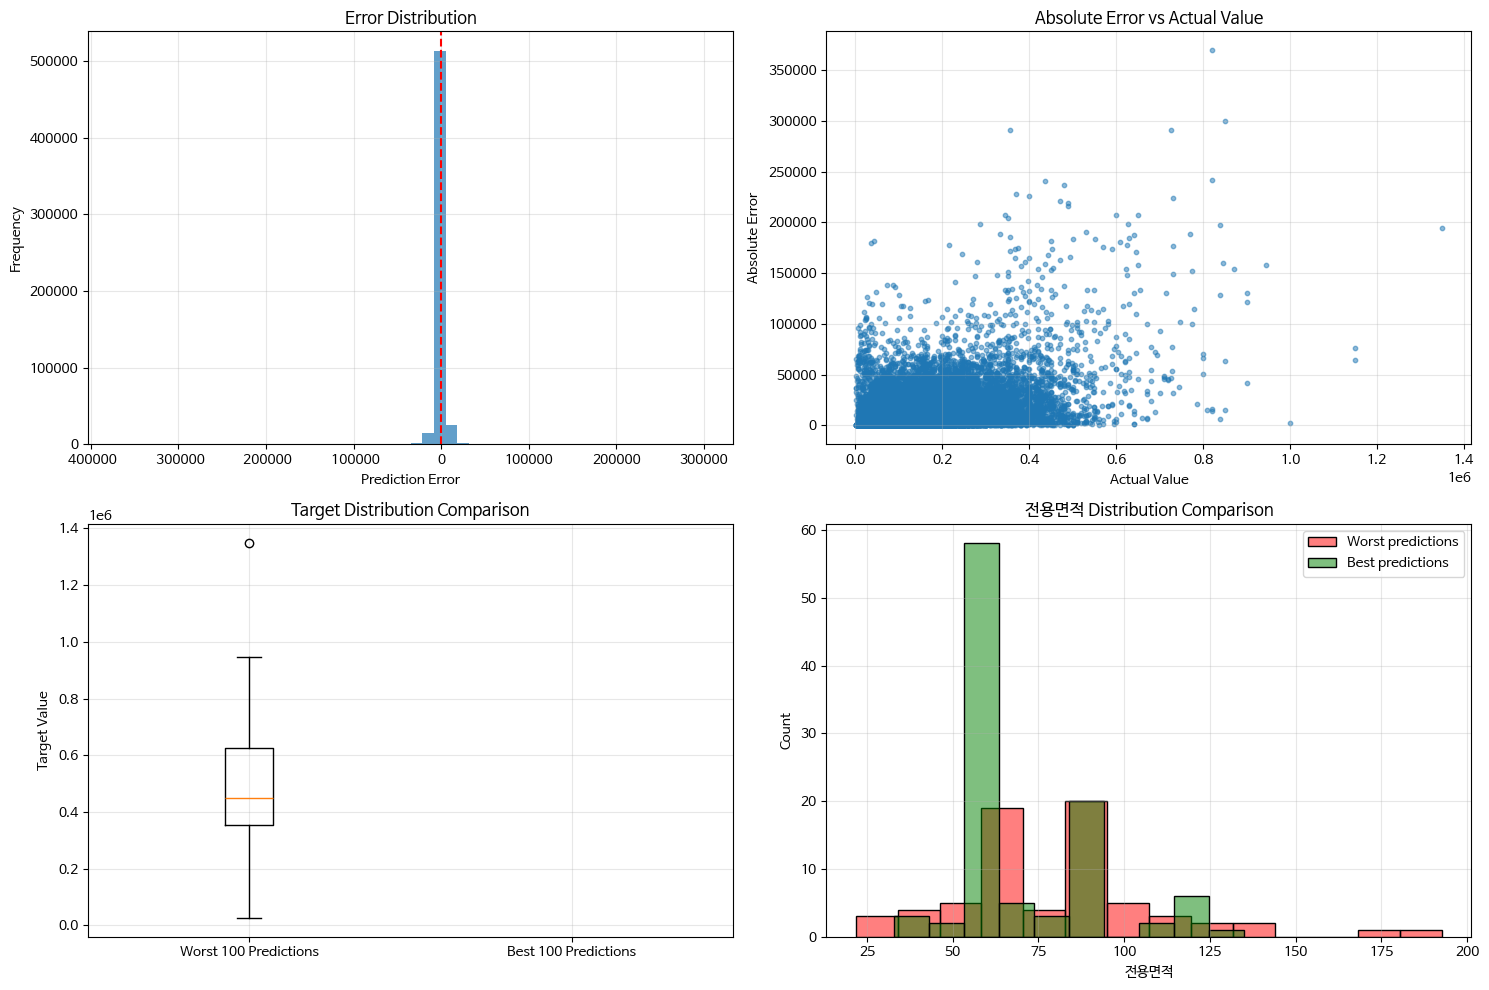


=== Features Related to High Error ===
Top 10 Features Most Correlated with Prediction Error:
              Feature  Correlation
0        has_bus_500m     0.023141
1       nearest_정류소번호     0.018923
2              대장_좌표X     0.015886
3                 좌표Y     0.013393
4     transport_score     0.012304
5         대장아파트_거리_구간     0.012261
6    nearest_역사명_dist     0.011291
7     has_subway_500m     0.011125
8  k-전용면적별세대현황(60㎡이하)     0.009895
9                건축면적     0.008066


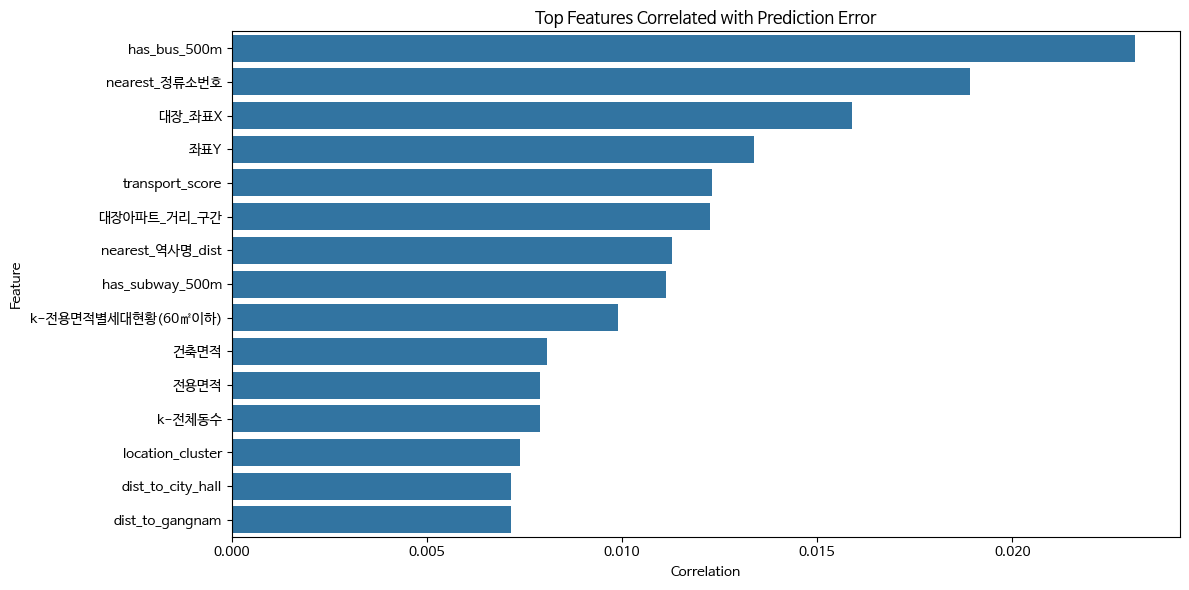

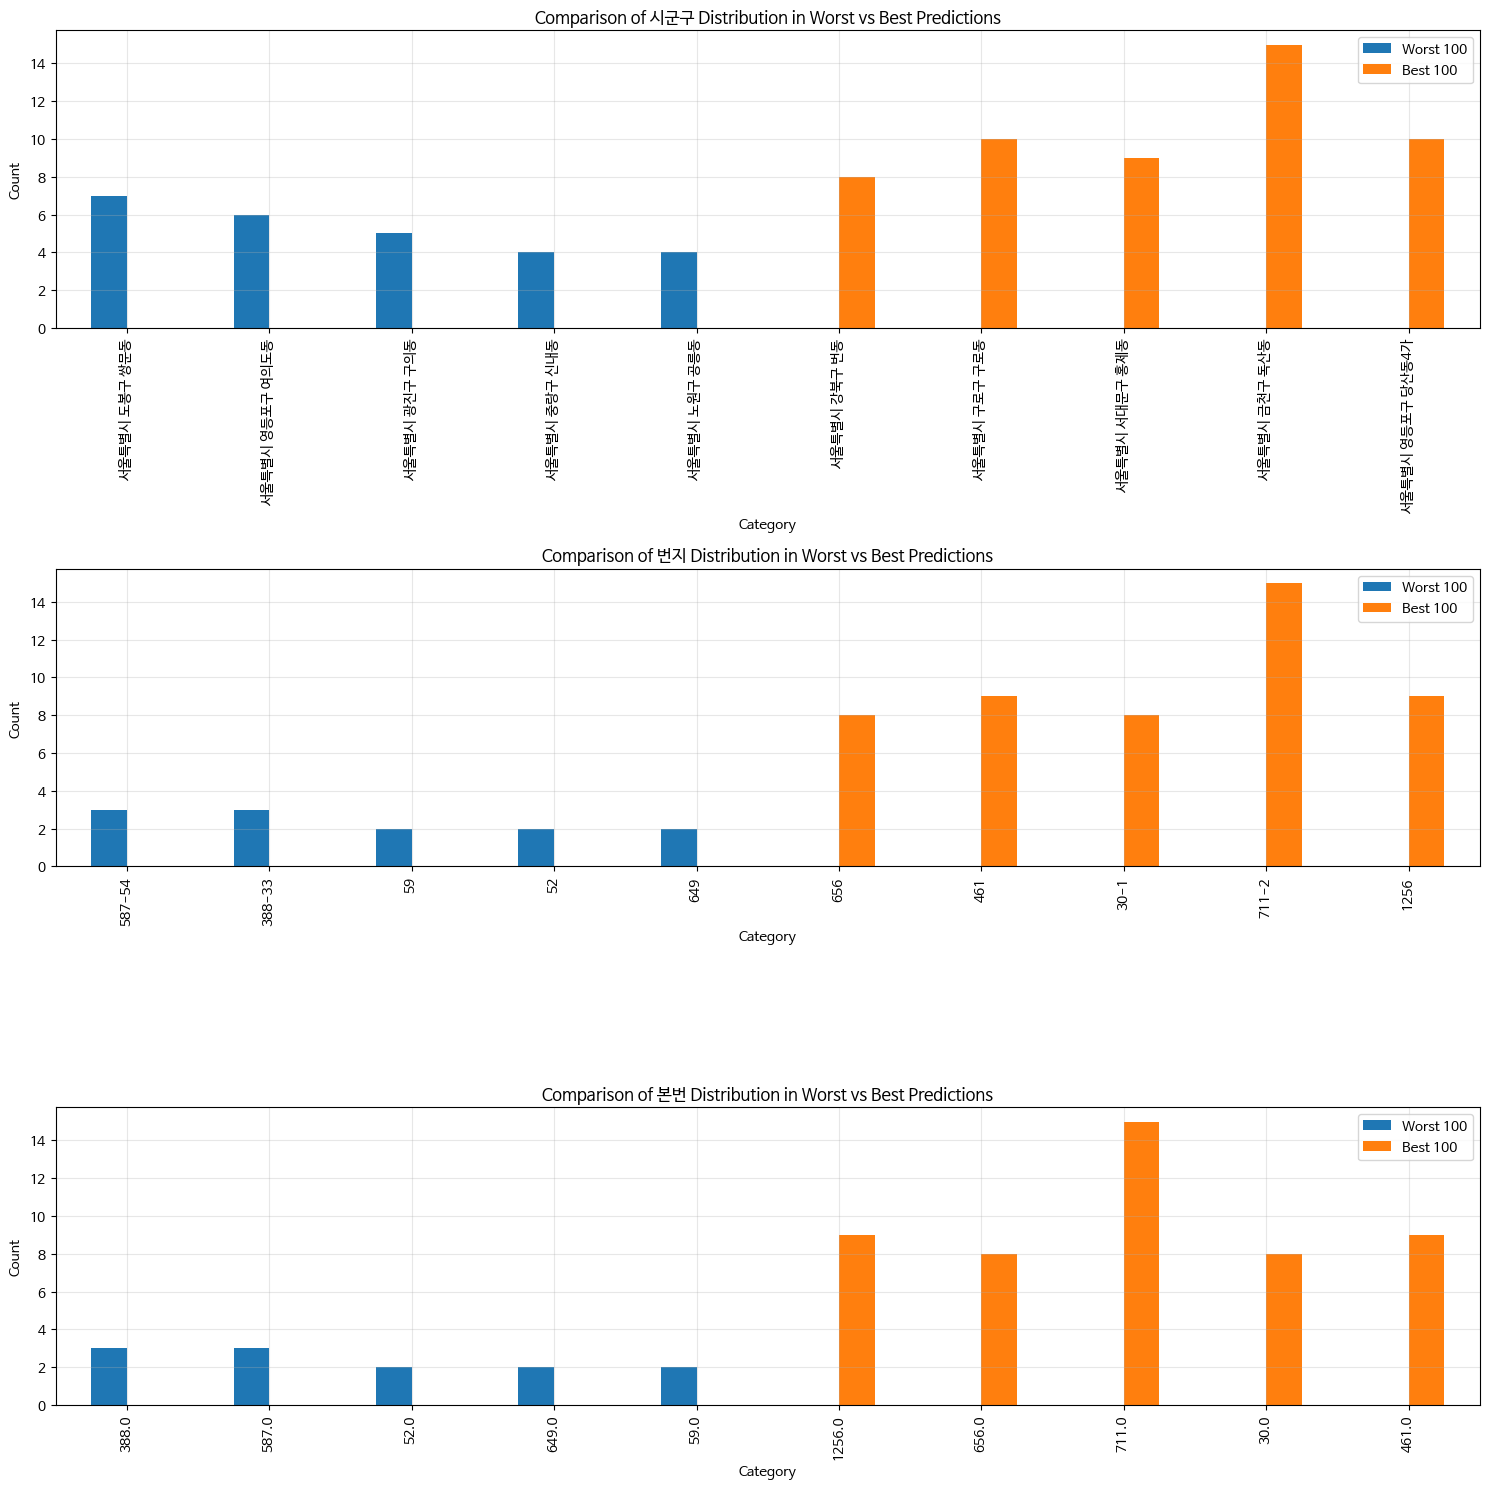

In [164]:
#############################################################
# 7.1 ERROR ANALYSIS VISUALIZATION
#############################################################
print("\n=== Error Analysis Visualization ===")

# We'll analyze the errors from the best model's validation set
# Create a DataFrame with predictions for analysis
analysis_df = pd.DataFrame({
    'actual': best_fold_data['y_val_orig'],
    'predicted': best_val_pred_orig,
})

# Calculate error metrics
analysis_df['error'] = analysis_df['predicted'] - analysis_df['actual']
analysis_df['abs_error'] = np.abs(analysis_df['error'])
analysis_df['squared_error'] = analysis_df['error'] ** 2
analysis_df['percent_error'] = 100 * np.abs(analysis_df['error'] / analysis_df['actual'])

# Merge with original features for analysis
X_best_val_orig = X_train.iloc[best_val_idx].reset_index(drop=True)
analysis_df = pd.concat([analysis_df, X_best_val_orig], axis=1)

# Sort by squared error descending
analysis_df_sorted = analysis_df.sort_values('squared_error', ascending=False)

# Get worst and best 100 predictions
worst_100 = analysis_df_sorted.head(100)
best_100 = analysis_df_sorted.tail(100)

# Inverse transform categorical columns for better interpretation
worst_100_decoded = worst_100.copy()
best_100_decoded = best_100.copy()

# Function to decode all categorical columns from a DataFrame
def decode_categorical_columns(df, encoders, cat_cols):
    df_decoded = df.copy()
    for col in cat_cols:
        if col in df.columns and col in encoders:
            try:
                df_decoded[col] = encoders[col].inverse_transform(df[col].astype(int))
            except:
                pass  # Skip if there's an error
    return df_decoded

# Apply decoding
worst_100_decoded = decode_categorical_columns(worst_100, best_label_encoders, categorical_columns)
best_100_decoded = decode_categorical_columns(best_100, best_label_encoders, categorical_columns)

# Basic error statistics
print("=== Error Statistics ===")
print(f"Mean Absolute Error: {analysis_df['abs_error'].mean():,.2f}")
print(f"Median Absolute Error: {analysis_df['abs_error'].median():,.2f}")
print(f"Mean Percentage Error: {analysis_df['percent_error'].mean():,.2f}%")
print(f"Median Percentage Error: {analysis_df['percent_error'].median():,.2f}%")

# Direction of errors
overpredict = (analysis_df['error'] > 0).sum()
underpredict = (analysis_df['error'] < 0).sum()
print(f"Overpredictions: {overpredict} ({overpredict/len(analysis_df)*100:.1f}%)")
print(f"Underpredictions: {underpredict} ({underpredict/len(analysis_df)*100:.1f}%)")

# Error distribution visualization
plt.figure(figsize=(15, 10))

# 1. Error distribution histogram
plt.subplot(2, 2, 1)
plt.hist(analysis_df['error'], bins=50, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 2. Absolute error vs actual
plt.subplot(2, 2, 2)
plt.scatter(analysis_df['actual'], analysis_df['abs_error'], alpha=0.5, s=10)
plt.title('Absolute Error vs Actual Value')
plt.xlabel('Actual Value')
plt.ylabel('Absolute Error')
plt.grid(True, alpha=0.3)

# 3. Box plot comparing worst and best predictions
plt.subplot(2, 2, 3)
data_to_plot = [worst_100['actual'], best_100['actual']]
plt.boxplot(data_to_plot, labels=['Worst 100 Predictions', 'Best 100 Predictions'])
plt.title('Target Distribution Comparison')
plt.ylabel('Target Value')
plt.grid(True, alpha=0.3)

# 4. Feature comparison for worst vs best predictions
# Select a key feature (e.g., area, which is often important for real estate)
key_feature = '전용면적'  # Adjust this to a feature in your dataset
plt.subplot(2, 2, 4)
sns.histplot(worst_100[key_feature], alpha=0.5, label='Worst predictions', color='red')
sns.histplot(best_100[key_feature], alpha=0.5, label='Best predictions', color='green')
plt.title(f'{key_feature} Distribution Comparison')
plt.xlabel(key_feature)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('error_analysis.png')
plt.show()



# Feature importance for error prediction - simplified approach
print("\n=== Features Related to High Error ===")

# Instead of training a model, let's analyze correlations with error
numeric_cols = [col for col in X_best_val_orig.columns 
                if pd.api.types.is_numeric_dtype(X_best_val_orig[col])]

# Create a DataFrame for correlation analysis
error_corr_df = X_best_val_orig[numeric_cols].copy()
error_corr_df['abs_error'] = analysis_df['abs_error']

# Calculate correlation with absolute error
corr_with_error = []
for col in numeric_cols:
    try:
        # Skip columns with NaN or infinite values
        if error_corr_df[col].isna().any() or np.isinf(error_corr_df[col]).any():
            continue
            
        corr = error_corr_df[col].corr(error_corr_df['abs_error'])
        if not np.isnan(corr):
            corr_with_error.append((col, abs(corr)))
    except:
        # Skip columns that cause errors
        continue

# Sort by correlation strength
corr_with_error.sort(key=lambda x: x[1], reverse=True)

# Create results DataFrame
error_importance = pd.DataFrame(corr_with_error, columns=['Feature', 'Correlation'])

# Print top features correlated with high error
print("Top 10 Features Most Correlated with Prediction Error:")
print(error_importance.head(10))

# Plot top error-correlated features (if we have any)
if len(error_importance) > 0:
    plt.figure(figsize=(12, 6))
    top_n = min(15, len(error_importance))
    sns.barplot(x='Correlation', y='Feature', data=error_importance.head(top_n))
    plt.title('Top Features Correlated with Prediction Error')
    plt.tight_layout()
    plt.savefig('error_feature_correlation.png')
    plt.show()
else:
    print("No valid correlations found with prediction error.")


# Plot prediction error by key categorical variables
key_cat_vars = []
for col in categorical_columns:
    if col in worst_100_decoded.columns:
        try:
            # Count occurrences in worst and best predictions
            worst_counts = worst_100_decoded[col].value_counts().nlargest(5)
            best_counts = best_100_decoded[col].value_counts().nlargest(5)
            
            # If there's overlap and sufficient variety
            if len(set(worst_counts.index) | set(best_counts.index)) >= 3:
                key_cat_vars.append(col)
                
            # Limit to 3 categorical variables for visualization
            if len(key_cat_vars) >= 3:
                break
        except:
            continue

# If we found key categorical variables, plot them
if key_cat_vars:
    plt.figure(figsize=(15, 5 * len(key_cat_vars)))
    
    for i, col in enumerate(key_cat_vars):
        plt.subplot(len(key_cat_vars), 1, i+1)
        
        # Get counts from worst and best
        worst_counts = worst_100_decoded[col].value_counts().nlargest(5)
        best_counts = best_100_decoded[col].value_counts().nlargest(5)
        
        # Get unique categories across both
        all_cats = list(set(worst_counts.index) | set(best_counts.index))
        
        # Create comparison DataFrame
        comp_data = []
        for cat in all_cats:
            worst_count = worst_counts[cat] if cat in worst_counts else 0
            best_count = best_counts[cat] if cat in best_counts else 0
            comp_data.append({
                'Category': cat,
                'Worst 100': worst_count,
                'Best 100': best_count
            })
        
        comp_df = pd.DataFrame(comp_data)
        comp_df = comp_df.sort_values('Worst 100', ascending=False)
        
        # Plot as grouped bar chart
        comp_df.plot(x='Category', y=['Worst 100', 'Best 100'], kind='bar', ax=plt.gca())
        plt.title(f'Comparison of {col} Distribution in Worst vs Best Predictions')
        plt.ylabel('Count')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('categorical_error_analysis.png')
    plt.show()

#### 8. INFERENCE ON TEST DATA

In [165]:
#############################################################
# 8. INFERENCE ON TEST DATA
#############################################################
print("Applying best model from fold", best_model_idx + 1)

# Get the best model and its parameters
best_model = best_model_info['model']
best_feature_scaler = best_model_info['feature_scaler']
best_label_encoders = best_model_info['label_encoders']
best_offset = best_model_info['offset']

# Preprocess test data using the preprocessing function
# Pass None for validation data since we don't need it for test inference
# test_data_processed = preprocess_fold_data(
#     X_train_fold=X_train.iloc[0:0],  # Empty DataFrame with same columns
#     y_train_fold=y_train.iloc[0:1],  # Just need one value to calculate offset
#     X_val_fold=None, 
#     y_val_fold=None,
#     X_test=X_test
# )

# Override preprocessed test data with best model's transformations
X_test_preprocessed = X_test.copy()

# Apply feature scaling from best model
X_test_preprocessed.loc[:, continuous_columns] = best_feature_scaler.transform(X_test[continuous_columns])

# Apply label encoding from best model
for col in categorical_columns:
    if col in X_test_preprocessed.columns and col in best_label_encoders:
        # Handle unseen categories
        for label in np.unique(X_test_preprocessed[col]):
            if str(label) not in best_label_encoders[col].classes_:
                best_label_encoders[col].classes_ = np.append(best_label_encoders[col].classes_, str(label))
        
        X_test_preprocessed.loc[:, col] = best_label_encoders[col].transform(X_test_preprocessed[col].astype(str))

# Make predictions on test data (in log space)
test_pred_log = best_model.predict(X_test_preprocessed)

# Transform back to original scale
test_pred_original = np.expm1(test_pred_log) - best_offset

# Convert to integers (if appropriate)
test_pred_final = np.round(test_pred_original).astype(int)

# Create submission file
submission = pd.DataFrame({'target': test_pred_final})
submission.to_csv('xgb_stratified_cv_submission_XY.csv', index=False)

print("Cross-validated model predictions generated successfully!")

# Save the best model
with open('xgb_best_cv_model.pkl', 'wb') as f:
    pickle.dump({
        'model': best_model,
        'feature_scaler': best_feature_scaler,
        'label_encoders': best_label_encoders,
        'offset': best_offset,
        'feature_names': X_train.columns.tolist(),
        'categorical_columns': categorical_columns,
        'continuous_columns': continuous_columns
    }, f)

print("Best cross-validation model saved!")

Applying best model from fold 2


/tmp/ipykernel_2796498/2733287992.py:26: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_test_preprocessed.loc[:, continuous_columns] = best_feature_scaler.transform(X_test[continuous_columns])
/tmp/ipykernel_2796498/2733287992.py:36: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_test_preprocessed.loc[:, col] = best_label_encoders[col].transform(X_test_preprocessed[col].astype(str))


Cross-validated model predictions generated successfully!
Best cross-validation model saved!
